In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
from mpl_toolkits.axes_grid1 import make_axes_locatable

from qick import *
from qick.helpers import gauss
from tqdm import tqdm_notebook as tqdm

import time
import os
expt_path=os.getcwd()+'/data'
import sys
import scipy as sp
import json

import qutip as qt
import qutip.visualization as qplt

from slab.instruments import *
from slab.experiment import Experiment
from slab.datamanagement import SlabFile
from slab import get_next_filename, AttrDict

# Figure params
plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams.update({'font.size': 16})
style.use('default')

np.set_printoptions(threshold=sys.maxsize)

Could not import QickSoc: No module named 'pynq'


c:\Users\slab\anaconda3\lib\site-packages\visa.py:13: FutureWarning: The visa module provided by PyVISA is being deprecated. You can replace `import visa` by `import pyvisa as visa` to achieve the same effect.

The reason for the deprecation is the possible conflict with the visa package provided by the https://github.com/visa-sdk/visa-python which can result in hard to debug situations.
  warnings.warn(


Warning serial library import failed.


c:\Users\slab\anaconda3\lib\site-packages\IPython\qt.py:12: ShimWarning: The `IPython.qt` package has been deprecated since IPython 4.0. You should import from qtconsole instead.
  warn("The `IPython.qt` package has been deprecated since IPython 4.0. "


Could not load InstrumentManagerWindow
Could not import QickInstrument, try install qick package
Could not load AD5780 dac 
Could not load labbrick
Could not load Autonics TM4 Driver
Could not load Oxford Trition driver


In [2]:
sys.path.append(os.getcwd()+'/../../qutip_sims')
from QSwitch import QSwitch
from PulseSequence import PulseSequence

# State tomography analysis functions

Measurement occurs along 9 axes, each of which can give one of 4 values:

ZZ, ZX, ZY, XZ, XX, XY, YZ, YX, YY -> {00, 01, 10, 11}

In [3]:
meas_order = np.array(['ZZ', 'ZX', 'ZY', 'XZ', 'XX', 'XY', 'YZ', 'YX', 'YY'])
calib_order = np.array(['gg', 'ge', 'eg', 'ee'])

## Getting rho from meas counts

First random helper method stuff for pauli matrices and dealing with the measurement order

In [4]:
def pauli(i): return [qt.qeye(2), qt.sigmax(), qt.sigmay(), qt.sigmaz()][i]

def s2i(s): # string to pauli matrix index
    return int(np.char.find('IXYZ', s))

def i2s(i): # pauli matrix index to string
    return 'IXYZ'[i]

def order(S12): # given 2 pauli matrix names, get the index at which that combo (or equivalent data) was measured
    assert S12[0] in 'IXYZ'
    assert S12[1] in 'IXYZ'
    # for the purposes of getting counts, measuring in I basis and Z basis are interchangeable
    if S12[0] == 'I': S12 = 'Z'+S12[1]
    if S12[1] == 'I': S12 = S12[0]+'Z'
    return np.argwhere(meas_order == S12)[0][0]
# print(order('II'))

Define psi basis

In [5]:
"""
Define basis in to be used when doing MLE
"""
# 2 cardinal points on Bloch sphere for each measurement axis
# psiZ = [qt.basis(3,0), qt.basis(3,1)]
psiZ = [qt.basis(2,0), qt.basis(2,1)]
psiX = [1/np.sqrt(2)*(psiZ[0]+psiZ[1]), 1/np.sqrt(2)*(psiZ[0]-psiZ[1])]
psiY = [1/np.sqrt(2)*(psiZ[0]+1j*psiZ[1]), 1/np.sqrt(2)*(psiZ[0]-1j*psiZ[1])]
psi_dict = dict(Z=psiZ, X=psiX, Y=psiY)

psi_basis = dict() # 36 elements
# psi_tensor = [psiZ[0], psiZ[0], psiZ[0], psiZ[0]]
for S12 in meas_order:
    S1, S2 = S12
    psi1 = psi_dict[S1]
    psi2 = psi_dict[S2]

    psi_basis.update({S12:[]})

    psi_basis[S12].append(qt.tensor(psi1[0], psi2[0])) # gg
    psi_basis[S12].append(qt.tensor(psi1[0], psi2[1])) # ge
    psi_basis[S12].append(qt.tensor(psi1[1], psi2[0])) # eg
    psi_basis[S12].append(qt.tensor(psi1[1], psi2[1])) # ee

    # print(psi_basis[S12])

psi_basis_flat = []
for S12 in meas_order:
    for psi in psi_basis[S12]:
        # measure in psi basis
        psi_basis_flat.append(psi)

# def get_psi_basis(qubits):
#     q0, q1 = qubits

#     for S12 in meas_order:
#         S1, S2 = S12
#         psi1 = psi[S1]
#         psi2 = psi[S2]

#         # gg
#         psi_tensor[q0] = psi1[0]
#         psi_tensor[q1] = psi2[0]
#         psi_basis.append(qt.tensor(*psi_tensor))

#         # ge
#         psi_tensor[q0] = psi1[0]
#         psi_tensor[q1] = psi2[1]
#         psi_basis.append(qt.tensor(*psi_tensor)) # ge

#         # eg 
#         psi_tensor[q0] = psi1[1]
#         psi_tensor[q1] = psi2[0]
#         psi_basis.append(qt.tensor(*psi_tensor)) # eg

#         # ee
#         psi_tensor[q0] = psi1[1]
#         psi_tensor[q1] = psi2[1]
#         psi_basis.append(qt.tensor(*psi_tensor)) # ee

#     return psi_basis

Convert single shot measurements into counts for each of the 9 measurement axes: 4x9=36 elements in the count array, then into the initial rho from experiment which will likely be unphysical.

In [6]:
"""
n should be length 4 array containing single shot counts of measuring 00, 01, 10, 11 for measurement along axes i, j
Converts n to Tij for use in the T^\dag T = rho matrix where measurement axes are S1 and S2: I, X, Y, Z
"""
def Tij(n, S1, S2):
    assert 0 <= S1 <= 3 # S1, S2 represent pauli matrix indices
    assert 0 <= S2 <= 3
    signs = [1]*4
    # eigenvalues of X, Y, Z are +/- 1, eigenvalues of I are +1
    if S1 > 0: signs[2] *= -1; signs[3] *= -1
    if S2 > 0: signs[1] *= -1; signs[3] *= -1
    return np.sum(np.multiply(signs, n))


In [7]:
h2 = -7/2*qt.tensor(qt.sigmaz(), qt.qeye(2)) - 9/2*qt.tensor(qt.qeye(2), qt.sigmaz())
print(h2.full())
evals = h2.eigenenergies()
print(h2.eigenstates())
print(evals - evals[0])

h2 = -7/2*qt.tensor(qt.sigmaz(), qt.qeye(2)) - 9/2*qt.tensor(qt.qeye(2), qt.sigmaz()) + 3/2*(qt.tensor(qt.sigmaz(), qt.sigmaz()))
print(h2.full())
evals = h2.eigenenergies()
print(h2.eigenstates())
print(evals - evals[0])

[[-8.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  1.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j -1.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  8.+0.j]]
(array([-8., -1.,  1.,  8.]), array([Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
       Qobj data =
       [[1.]
        [0.]
        [0.]
        [0.]]                                                             ,
       Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
       Qobj data =
       [[0.]
        [0.]
        [1.]
        [0.]]                                                             ,
       Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
       Qobj data =
       [[0.]
        [1.]
        [0.]
        [0.]]                                                             ,
       Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
       Qobj data =
       [[0.]
        [0.]
        [0.]
        [1.]]                                                        

In [8]:
"""
Construct rho by adding together Tij for each of the 4^2 = 16 combinations of tensor product of 2 Pauli matrices
"""
def rho_from_counts(n):
    rho = 0*qt.tensor(qt.qeye(2), qt.qeye(2))
    for i in range(4): # loop over pauli matrices for qubit 1
        for j in range(4): # loop over pauli matrices for qubit 2
            o = order(i2s(i) + i2s(j)) # get the right 4 elements in the n matrix
            # print(i2s(i), i2s(j), Tij(n[4*o:4*(o+1)], i, j))
            rho += Tij(n[4*o:4*(o+1)], i, j) * qt.tensor(pauli(i), pauli(j))
    rho = rho.unit() # normalize
    rho = rho.tidyup(1e-10) # remove small elements
    rho = rho.full()

    # # expand rho into a 4 qubit subspace
    # q0, q1 = qubits
    # if q0 > q1: rho = qt.qip.gates.swap(N=4, targets=qubits).full() @ rho
    # id = qt.qeye(2)
    # tensor = [id, id, id]
    # tensor[min((q0, q1))] = rho
    # rho = qt.tensor(*tensor)
    # if max((q0, q1)) - min((q0, q1)) > 1:
    #     rho = qt.qip.gates.swap(N=4, targets=[min((q0, q1)) + 1, max((q0, q1))])

    return rho

### Generate test data

In [9]:
def generate_counts(rho_id, n_tot, psi_basis_flat=None, evol_mats=None, noise=1.0):
    assert psi_basis_flat or evol_mats
    
    if psi_basis_flat is not None:
        print('Generating with psi basis')
        n = []
        # psi_basis = get_psi_basis(qubits)
        for psi in psi_basis_flat:
            # measure in psi basis
            n.append(n_tot * (psi.dag() * rho_id * psi).tr())
        n = np.reshape(np.array(n), (len(psi_basis.keys()), 4))
    
    elif evol_mats is not None:
        print('Generating with evol mats')
        evals, evecs = np.linalg.eig(rho_id)
        evals = np.real(evals)
        n_evol = []
        for basis in meas_order:
            evol_mat = evol_mats[basis] # evol_mat sends each psi_ij to the evolved ket
            n_basis_th = np.zeros(4)
            for i in range(4):
                evec_evol = evol_mat @ evecs.T[i]
                if evals[i] > 1e-12: n_basis_th += evals[i] * n_tot * abs(evec_evol)**2 # add counts weighted by eval
            n_evol.append(n_basis_th)
        n_evol = np.array(n_evol)
        return n_evol

    # introduce gaussian noise
    if noise is not None:
        for n_psi in n:
            n_meas = sum(n_psi)
            new_n3 = -1
            while new_n3 < 0:
                new_n012 = np.random.normal(loc=n_psi[:3], scale=noise*np.sqrt(n_psi[:3]))
                # preserve original total count per measurement
                new_n3 = n_meas - sum(new_n012)
            n_psi[:3] = np.round(new_n012)
            n_psi[3] = np.round(new_n3)
    return n

### Error mitigation
Readout error means state prepared in |gg> will also have counts in |ge>, |eg>, |ee>; apply inverse of confusion matrix to correct. See qiskit measurement error mitigation procedure: [https://qiskit.org/textbook/ch-quantum-hardware/measurement-error-mitigation.html](https://qiskit.org/textbook/ch-quantum-hardware/measurement-error-mitigation.html)

maybe need to do something about fixing negative counts, but for now I will not. it should be automatically resolved in the MLE.

In [10]:
def correct_readout_err(n, n_conf):
    conf_mat = np.array(n_conf, dtype=float)
    for r, row in enumerate(conf_mat):
        conf_mat[r] /= sum(row) # normalize so counts for each state prep sum to 1
    conf_mat = np.transpose(conf_mat) # want counts for each state prep on columns
    conf_mat_inv = np.linalg.inv(conf_mat)
    # C_id = invM . C_noisy
    n = np.array(n, dtype=float)
    for r in range(len(n)):
        n[r] = (conf_mat_inv @ n[r].T).T
    return np.around(n, decimals=5)

In [11]:
def fix_neg_counts(counts):
    counts = np.array(counts)
    assert len(counts.shape) == 2 # 2d array

    for i_n, n in enumerate(counts):
        while len(n[n<0]) > 0: # repeat while still has neg counts
            assert sum(n) > 0, 'Negative sum of counts'
            neg_indices = np.where(n<0)[0]
            neg_vals = n[n<0]
            len_pos = len(n) - len(neg_vals)
            n += sum(neg_vals)/len_pos # redistribute the negative counts over all the positive elements evenly
            for i in neg_indices:
                n[i] = 0

        counts[i_n] = np.round(n)
    return counts

## Fix rho to a physical density matrix using MLE
Initial counts will be unphysical. Use MLE to map counts to a physical density matrix.

### Cholesky-esque decomposition functions

In [12]:
# Modification of np.diag_indices to allow off diagonal entries
# n = dim, k < 0 = lower diagonals, k > 0 = upper diagonals
def diag_indices_k(a, k):
    rows, cols = np.diag_indices_from(a)
    if k < 0: return rows[-k:], cols[:k]
    elif k > 0: return rows[:-k], cols[k:]
    else: return rows, cols

def T_flat2mat(t):
    # T_mat = []
    # T_mat.appen(np.array([t[0],           0,              0,               0]))
    # T_mat.append(np.array([t[4] +1j*t[5],  t[1],           0,               0]))
    # T_mat.append(np.array([t[10]+1j*t[11], t[6]+1j*t[7],   t[2],            0]))
    # T_mat.append(np.array([t[14]+1j*t[15], t[12]+1j*t[13], t[8]+1j*t[9], t[3]]))
    d = int(np.sqrt(len(t)))
    t_complex = np.zeros(int(d + (len(t)-d)/2), dtype=complex)
    t_complex[:d] = t[:d]
    for i in range(d, len(t_complex)):
        t_complex[i] = t[d + (i-d)*2] + 1j*t[d + (i-d)*2 + 1]
    T_mat = np.zeros(shape=(d,d), dtype=complex)
    start_i = 0
    for k in range(d):
        T_mat[diag_indices_k(T_mat, -k)] = t_complex[start_i:start_i+(d-k)]
        start_i += d - k
    return np.array(T_mat)


USE THESE (need to handle divide by 0 errors, which the more general method does not handle)

This is taken from [James et al. 2001](https://journals.aps.org/pra/pdf/10.1103/PhysRevA.64.052312), eq. 4.6.

In [13]:
def det_ij(rho, i, j):
    M = np.delete(rho, i, axis=0)
    M = np.delete(M, j, axis=1)
    return np.linalg.det(M)

def det_ijkl(rho, i, j, k, l):
    M = np.delete(rho, [i,k], axis=0)
    M = np.delete(M, [j,l], axis=1)
    return np.linalg.det(M)

def t_from_rho(rho):
    t = []
    det = np.linalg.det(rho)
    det00 = det_ij(rho, 0, 0)
    det01 = det_ij(rho, 0, 1)
    det0011 = det_ijkl(rho, 0, 0, 1, 1)
    det0012 = det_ijkl(rho, 0, 0, 1, 2)
    det0112 = det_ijkl(rho, 0, 1, 1, 2)
    # ensure no divide by 0 errors since this algo is intended for positive definite matrices
    # if det == 0: det = 1e-10
    # if det00 == 0: det00 = 1e-10
    # if det0011 == 0: det0011 = 1e-10
    # if det0012 == 0: det0012 = 1e-10
    # if det0112 == 0: det0112 = 1e-10
    rho33 = rho[3,3]
    # if rho33 == 0: rho33 = 1e-10
    t = [
        0 if det00 == 0 else np.sqrt(det/det00),
        0 if det0011 == 0 else np.sqrt(det00/det0011),
        0 if rho33 == 0 else np.sqrt(det0011/rho33),
        np.sqrt(rho[3,3])
        ]
    t56 = 0 if det00*det0011 == 0 else det01/np.sqrt(det00*det0011)
    t.extend([np.real(t56), np.imag(t56)])

    t78 = 0 if rho33*det0011 == 0 else det0012/np.sqrt(rho33*det0011)
    t.extend([np.real(t78), np.imag(t78)])

    t910 = 0 if rho33 == 0 else rho[3,2]/np.sqrt(rho33)
    t.extend([np.real(t910), np.imag(t910)])

    t1112 = 0 if rho33*det0011 == 0 else det0112/np.sqrt(rho33*det0011)
    t.extend([np.real(t1112), np.imag(t1112)])

    t1314 = 0 if rho33 == 0 else rho[3,1]/np.sqrt(rho33)
    t.extend([np.real(t1314), np.imag(t1314)])

    t1516 = 0 if rho33 == 0 else rho[3,0]/np.sqrt(rho33)
    t.extend([np.real(t1516), np.imag(t1516)])

    assert(len(t)==16)
    return np.real(np.array(t)) # take the real since rho may be slightly non-positive semi definite, so det(rho) may be slightly negative

def rho_from_t(t):
    T = T_flat2mat(t)
    rho = T.conj().T @ T
    return rho / np.trace(rho)

Not using this

Cholesky-Banachiewicz algorithm - valid for positive definite matrices, so need to ensure no divide by 0 errors. This doesn't seem to work?

In [204]:
# def t_from_rho(rho):
#     t = []
#     T = np.zeros(shape=np.shape(rho))
#     d = np.shape(rho)[0]
#     for i in range(d):
#         for j in range(i+1):
#             sum = 0
#             for k in range(j):
#                 sum += T[i, k] * T[j, k]
#             if i == j: T[i, i] = np.sqrt(rho[i, i] - sum)
#             else:
#                 Tjj = T[j, j]
#                 if Tjj == 0: Tjj = 1e-10
#                 T[i, j] = (rho[i, j] - sum) / Tjj
#     t = np.diagonal(T)
#     for k in range(1, d):
#         t_complex = np.diag(T, k=-k)
#         for t_i in t_complex:
#             t = np.append(t, [np.real(t_i), np.imag(t_i)])
#     assert(len(t)==16)
#     return np.real(t)
    
# def rho_from_t(t):
#     T = T_flat2mat(t)
#     rho = T @ T.conj().T
#     return rho / np.trace(rho)

### ZZ correction
Instead of using bare psis in MLE, introduce ZZ coupling in Hamiltonian and use the pulse shapes used in the tomography pulse sequence to simulate the expected final state of each of the psis. Then use these corrected "evolution states" to match the MLE.

Note: uses QSwitch and related classes

In [799]:
"""
Get effective drive rate in GHz
"""
sigma_n = 4 # total number of sigmas in gaussian
def amp_eff(sigma_ns, sigma_n=sigma_n):
    return 1/4 / (sigma_ns * np.sqrt(2*np.pi) * sp.special.erf(sigma_n/2 / np.sqrt(2)))

In [832]:
def get_evol_mats(qubits, qfreqs, ZZs, pulse_dict, dt=0.01):
# def get_evol_mats(qubits, qfreqs, alphas, pulse_dict):
    assert len(pulse_dict.items()) == len(meas_order)
    # print("WARNING: current gain to freq conversion for rfsoc is very fake!", flush=True)
    evol_mats = dict()
    device = QSwitch(qubit_freqs=qfreqs, ZZs=ZZs, cutoffs=[2,2], useZZs=True, is2Q=True)

    # Get the pi/2 pulse lengths for both qubits
    pulse_cfgs_XX = pulse_dict['XX']
    pi2_lens = [0]*2
    pi2_types = [None]*2
    for pulse_name, pulse_cfg in pulse_cfgs_XX.items():
        if pulse_cfg['flag'] != 'ZZcorrection': continue
        drive_qubit = int(pulse_cfg['name'][-1]) # get the qubit number
        assert drive_qubit in qubits

        # convert drive qubit out of 4 to drive qubit in a 2Q Hamiltonian
        drive_qubit = qubits.index(drive_qubit)
        pi2_types[drive_qubit] = pulse_cfg['type']
        if pi2_types[drive_qubit] == 'gauss':
            pulse_len = pulse_cfg['sigma']
        elif pi2_types[drive_qubit] == 'const':
            pulse_len = pulse_cfg['length']
        pi2_lens[drive_qubit] = soc.cycles2us(pulse_len, gen_ch=pulse_cfg['ch']) * 1e3
    assert 0 not in pi2_lens

    for basis, pulse_cfgs in tqdm(pulse_dict.items()):
        print(basis)
        seq = PulseSequence()

        # print('all pulse_cfgs for basis', basis, pulse_cfgs)
        for drive_qubit in (0, 1):
            if basis[drive_qubit] == 'Z':
                device.add_precise_pi_pulse(seq, 'gg', 'gg', amp=0, drive_qubit=drive_qubit, wd=-1, phase=0, type=pi2_types[drive_qubit], t_pulse=pi2_lens[drive_qubit], t_offset=0, sigma_n=sigma_n)
                continue

            # Find the appropriate pulse cfg for the pulse
            for pulse_name, pulse_cfg in pulse_cfgs.items():
                # print('flag', pulse_cfg['flag'])
                if pulse_cfg['flag'] != 'ZZcorrection': continue
                # print(pulse_name)
                pulse_qubit = int(pulse_cfg['name'][-1]) # get the qubit number
                assert pulse_qubit in qubits
                # convert drive qubit out of 4 to drive qubit in a 2Q Hamiltonian, proceed if this is the drive qubit we want
                if qubits.index(pulse_qubit) != drive_qubit: continue

                ch = pulse_cfg['ch']
                freq = pulse_cfg['freq_MHz']
                freq += 4000 if freq < 1000 else 0
                wd = 2*np.pi * freq * 1e-3
                # phase = -np.pi/2 - pulse_cfg['phase_deg'] * np.pi/180 # convert from the cos wavefunction used in definition of rfsoc drive to the sin wavefunction used for simulations
                phase = pulse_cfg['phase_deg'] * np.pi/180
                type = pulse_cfg['type']

                pulse_length = pi2_lens[drive_qubit] # ns
                assert pulse_length > 1 # 1 ns
                amp = amp_eff(pulse_length, sigma_n=sigma_n)
                # print(pulse_length, amp)

                new_state = 'gg'
                new_state = new_state[:drive_qubit] + 'e' + new_state[drive_qubit+1:]
                print(new_state)
                device.add_precise_pi_pulse(seq, 'gg', new_state, amp=amp, drive_qubit=drive_qubit, wd=wd, phase=phase, type=type, t_pulse=pulse_length, t_offset=0, sigma_n=sigma_n)

                # print('all params')
                print('fd', wd/2/np.pi)
                print('pulse length', pulse_length)
                print('amp', amp)
                print('phase rad', phase)
                print('drive q', drive_qubit)

        total_length = sum(seq.get_pulse_lengths())
        nsteps = int(total_length // dt + 1)
        times = np.linspace(0, total_length, num=nsteps)

        envelope_seq = seq.get_envelope_seq()
        pulse_amps = seq.get_pulse_amps()
        print(seq.get_pulse_freqs(), '(GHz)')
        print(seq.get_pulse_amps(), '(GHz)')
        print(seq.get_pulse_lengths(), '(ns)')
        print('total pulse length', sum(seq.get_pulse_lengths()), 'ns')
        for i in range(len(envelope_seq)):
            plt.plot(times, [pulse_amps[i]*envelope_seq[i](t)*1e3 for t in times], label=f'Pulse {i}')
        plt.xlabel('Time (ns)')
        plt.ylabel('Drive Amplitude (MHz)')
        plt.title(f'Pulse Sequence {basis}')
        plt.legend()
        plt.show()

        # pulse_index = np.where(np.array(meas_order)==str(basis))[0][0]
        # psi_basis = get_psi_basis(qubits)

        # print('total length', total_length)
        evol_mats.update({basis:[]})
        # for psi0 in psi_basis[basis]:
        #     times = [0, total_length]
        #     evol_mats[basis].append(device.evolve(psi0, seq, times, nsteps=100000, use_str_solve=False, progress=False)[-1])
        #     print('basis', basis, 'overlap', abs(psi0.overlap(evol_mats[basis][-1]))**2)
        for state0 in range(2):
            for state1 in range(2):
                psi0 = qt.ket(str(state0)+str(state1))
                evol_ket = device.evolve_array(psi0, seq, times, nsteps=100000, use_str_solve=False, progress=False)[-1]
                # print('basis', basis, 'overlap', abs(psi_basis[basis][state0*2+state1].overlap(evol_ket))**2)

                for ref_state in ['gg', 'ge', 'eg', 'ee']:
                    state = device.state(ref_state)
                    print(ref_state, 'prob', np.abs(state.overlap(evol_ket))**2)

                evol_mats[basis].append(evol_ket.unit())
                # evol_mats[basis].append(evol_ket.full().transpose())
        evol_mats[basis] = np.hstack(evol_mats[basis])
        
        # envelope_seq = seq.get_envelope_seq()
        # pulse_amps = seq.get_pulse_amps()
        # print(seq.get_pulse_freqs(), '(GHz)')
        # print(seq.get_pulse_lengths(), '(ns)')
        # print('total pulse length', sum(seq.get_pulse_lengths()), 'ns')
        # plot_times = np.linspace(0, total_length, 100)
        # for i in range(len(envelope_seq)):
        #     plt.plot(plot_times, [pulse_amps[i]*envelope_seq[i](t)*1e3 for t in plot_times], label=f'Pulse {i}')
        # plt.xlabel('Time (ns)')
        # plt.ylabel('Drive Amplitude (MHz)')
        # plt.title('Pulse Sequence')
        # plt.legend()
        # plt.show()

    return evol_mats

### MLE functions

In [16]:
def run_MLE_standard(n, rho_guess=None, rho_id=None, method='L-BFGS-B', decimals=10):
    # methods = 'Nelder-Mead' 'Powell' 'CG' 'BFGS' 'Newton-CG' 'L-BFGS-B' 'TNC' 'COBYLA' 'SLSQP' 'dogleg' 'trust-ncg'
    if rho_guess is None: rho_guess = rho_from_counts(n)
    n_tot = sum(n)
    # psi_basis = get_psi_basis(qubits)
    def likelihood(t_arr):
        rho = rho_from_t(t_arr)
        rho = rho / np.trace(rho)
        val = 0
        for psi, n_val in zip(psi_basis_flat, n.flatten()):
            psi = psi.full()
            proj = (psi.conj().T @ rho @ psi)[0][0]
            if proj != 0:
                val += np.real(abs(n_tot * proj - n_val)**2 / (n_tot * proj))
        # return np.log(val)
        return val
    optvals = sp.optimize.minimize(likelihood, t_from_rho(rho_guess), method=method)
    print(f'Convergence: {optvals.success}')
    return np.around(rho_from_t(optvals.x), decimals=decimals)

In [876]:
def run_MLE_ZZ(n, evol_mats, rho_guess=None, rho_id=None, method='L-BFGS-B', decimals=10):
    # methods = 'Nelder-Mead' 'Powell' 'CG' 'BFGS' 'Newton-CG' 'L-BFGS-B' 'TNC' 'COBYLA' 'SLSQP' 'dogleg' 'trust-ncg'
    if rho_guess is None: rho_guess = rho_from_counts(n)
    n_tot = sum(n)
    # psi_basis = get_psi_basis(qubits)
    def likelihood(t_arr):
        rho = rho_from_t(t_arr)
        rho = rho / np.trace(rho)
        val = 0
        # for psi, n_val in zip(evol_mats, n.flatten()):
        #     psi = psi.full()
        #     proj = (psi.conj().T @ rho @ psi)[0][0]
        #     if proj != 0:
        #         val += np.real(abs(n_tot * proj - n_val)**2 / (n_tot * proj))
        # # return np.log(val)
        # return val

        evals, evecs = np.linalg.eig(rho)
        evals = np.real(evals)
        n_evol = []
        for basis in meas_order:
            evol_mat = evol_mats[basis] # evol_mat sends each psi_ij to the evolved ket
            n_basis_th = np.zeros(4)
            for i in range(4):
                if evals[i] < 1e-12: continue
                evec_evol = evol_mat @ evecs.T[i]
                n_basis_th += evals[i] * n_tot * abs(evec_evol)**2 # add counts weighted by eval
            n_evol.append(n_basis_th)
        n_evol = np.array(n_evol)

        for n_th, n_expt in zip(n_evol.flatten(), n.flatten()):
            if n_th != 0: val += abs((n_th - n_expt)**2 / n_th)
        return val

    optvals = sp.optimize.minimize(likelihood, t_from_rho(rho_guess), method=method)
    print(f'Convergence: {optvals.success}')
    return np.around(rho_from_t(optvals.x), decimals=decimals)

In [18]:
def run_MLE(n, ZZ_correction=False, evol_mats=None, rho_guess=None, rho_id=None, method='L-BFGS-B'):
    if ZZ_correction: return run_MLE_ZZ(n, evol_mats, rho_guess=rho_guess, rho_id=rho_id, method=method)
    else: return run_MLE_standard(n, rho_guess=rho_guess, rho_id=rho_id, method=method)

In [941]:
qt.qip.operations.gates.rx(np.pi).full()

array([[6.123234e-17+0.j, 0.000000e+00-1.j],
       [0.000000e+00-1.j, 6.123234e-17+0.j]])

Optimize over virtual Z gates on ideal rho 

In [907]:
def z_gate_2q(phi1, phi2):
    return qt.tensor(qt.qip.operations.gates.rz(phi1), qt.qip.operations.gates.rz(phi2)) 

# The experimental density matrix from MLE may be offset from the simulated/ideal density matrix by a Z gate - due to different pulse times, ac stark shifts, etc.
def opt_virtualZ_MLE(rho_MLE, rho_id, nphi=100):
    phis = np.linspace(0, 2*np.pi, nphi)
    best_fid = 0
    best_phis = [0, 0]
    best_rho_id = rho_id
    for phi1 in tqdm(phis):
        for phi2 in phis:
            z_phi12 = z_gate_2q(phi1, phi2)
            rho_id_rot = (z_phi12*rho_id*z_phi12.dag()).unit()
            fid = qt.fidelity(rho_MLE, rho_id_rot)**2
            # print(fid)
            if fid > best_fid:
                best_fid = fid
                best_phis = [phi1*180/np.pi, phi2*180/np.pi]
                best_rho_id = rho_id_rot
    print(f'Improved fidelity by (%) {(best_fid - qt.fidelity(rho_MLE, rho_id)**2)*100}')
    return best_rho_id, best_phis, best_fid

# Plotting functions

In [19]:
# from qutip.visualization import hinton

In [662]:
def show_mat_2d(mat, ax, title, labels, cmax=1, show=True):
    """
    Plot an arbitrary 2D matrix with labels
    """
    plt.sca(ax)
    plt.title(title, fontsize=16)
    plt.imshow(np.real(mat), cmap='RdBu')
    # hinton(np.real(mat), xlabels=labels, ylabels=labels)
    plt.xticks(np.arange(len(mat)), labels, fontsize=15)
    plt.yticks(np.arange(len(mat)), labels, fontsize=15)
    # Loop over data dimensions and create text annotations.
    for ii in range(len(mat)):
        for jj in range(len(mat)):
            plt.text(ii, jj, round(mat[jj, ii], 3), ha="center", va="center", color="w", size=15)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(cax=cax)
    cbar.ax.tick_params(labelsize=14)
    plt.clim(vmin=-cmax, vmax=cmax)
    plt.tight_layout()
    if show: plt.show()

def show_plot_rho_2d(rho_MLE, rho_id=None, title=None, cmax=None):
    """
    Plot real and imag parts of rho, optionally also with a comparison ideal rho
    """
    labels = ["00", "01", "10", "11"]
    if rho_id is None:
        fig = plt.figure(figsize=(15, 5))
        ax1 = fig.add_subplot(121)
        ax2 = fig.add_subplot(122)
    else:
        fig = plt.figure(figsize=(15, 12))
        ax1 = fig.add_subplot(221)
        ax2 = fig.add_subplot(222)
        ax3 = fig.add_subplot(223)
        ax4 = fig.add_subplot(224)
    plt.suptitle(title, fontsize=18)
    if cmax is None: cmax = np.max(np.abs(np.array([np.real(rho_MLE), np.imag(rho_MLE), np.real(rho_id), np.imag(rho_id)])))
    show_mat_2d(np.real(rho_MLE), ax=ax1, title="Re[$\\rho_{MLE}$]", labels=labels, cmax=cmax, show=False)
    show_mat_2d(np.imag(rho_MLE), ax=ax2, title="Im[$\\rho_{MLE}$]", labels=labels, cmax=cmax, show=False)
    show_mat_2d(np.real(rho_id), ax=ax3, title="Re[$\\rho_{Ideal}$]", labels=labels, cmax=cmax, show=False)
    show_mat_2d(np.imag(rho_id), ax=ax4, title="Im[$\\rho_{Ideal}$]", labels=labels, cmax=cmax, show=False)
    plt.show()

In [21]:
# Author: Ziqian
def show_plot_rho_3d(rho_MLE, rho_id=None):
    if rho_id is None:
        fig = plt.figure(figsize=(15, 5))
        ax1 = fig.add_subplot(121, projection='3d')
        ax2 = fig.add_subplot(122, projection='3d')
    else:
        fig = plt.figure(figsize=(15, 10))
        ax1 = fig.add_subplot(221, projection='3d')
        ax2 = fig.add_subplot(222, projection='3d')
        ax3 = fig.add_subplot(223, projection='3d')
        ax4 = fig.add_subplot(224, projection='3d')
    
    labels = ["00", "01", "10", "11"]
    qplt.matrix_histogram(np.real(rho_MLE), labels, labels, limits=[-0.5,0.5], ax=ax1)
    qplt.matrix_histogram(np.imag(rho_MLE), labels, labels, limits=[-0.5,0.5], ax=ax2)
    if rho_id is not None:
        qplt.matrix_histogram(np.real(rho_id), labels, labels, limits=[-0.5,0.5], ax=ax3)
        qplt.matrix_histogram(np.imag(rho_id), labels, labels, limits=[-0.5,0.5], ax=ax4)
    
    ax1.view_init(azim=-55, elev=45)
    ax2.view_init(azim=-55, elev=45)
    ax1.set_title("Re[$\\rho_{MLE}$]")
    ax2.set_title("Im[$\\rho_{MLE}$]")
    if rho_id is not None:
        ax3.view_init(azim=-55, elev=45)
        ax4.view_init(azim=-55, elev=45)
        ax3.set_title("Re[$\\rho_{ideal}$]")
        ax4.set_title("Im[$\\rho_{ideal}$]")
    plt.show()

# Run experiment and analysis

In [22]:
# %aimport experiments
# NOTE: ADDING NEW METHODS WILL NOT BE UPDATED
import experiments as meas

imported experiments.clifford_averager_program
imported experiments.fitting
imported experiments.qram_protocol_timestepped
imported experiments.single_qubit.acstarkshift_spectroscopy
imported experiments.single_qubit.amplitude_rabi
imported experiments.single_qubit.length_rabi
imported experiments.single_qubit.pulse_probe_ef_spectroscopy
imported experiments.single_qubit.pulse_probe_spectroscopy
imported experiments.single_qubit.resonator_spectroscopy
imported experiments.single_qubit.rfsoc_tof_calibration
imported experiments.single_qubit.single_shot
imported experiments.single_qubit.t1
imported experiments.single_qubit.t2_echo
imported experiments.single_qubit.t2_ramsey
imported experiments.two_qubit.amplitude_rabi_EgGf
imported experiments.two_qubit.DONOTUSE_ramsey_EgGf
imported experiments.two_qubit.length_rabi_EgGf
imported experiments.two_qubit.pulse_probe_coupling_spectroscopy
imported experiments.two_qubit.pulse_probe_EgGf_spectroscopy
imported experiments.two_qubit.randbench
i

In [264]:
"""Reopen saved data"""
def prev_data(expt_path, filename):
    temp_data_file = expt_path+'\\'+filename
    print(temp_data_file)
    with SlabFile(temp_data_file) as a:
        attrs = dict()
        for key in list(a.attrs):
            attrs.update({key:json.loads(a.attrs[key])})
        keys = list(a)
        temp_data = dict()
        for key in keys:
            temp_data.update({key:np.array(a[key])})
        print(f'Extracted data and attrs {list(a.attrs)}')
    return temp_data, attrs

In [24]:
# expt_path = os.getcwd()+'\data'
# expt_path = 's:\\Connie\\experiments\\20220430_2Transmon\\data'
# expt_path = os.getcwd()+'\\data_220712'
expt_path=os.getcwd()+'\data\data_221215'
print('Data will be stored in', expt_path)

Data will be stored in s:\Connie\experiments\qramLL_4QR2\data\data_221215


In [25]:
# config_file = 'config_zcu216.yml'
config_file = 'config_q3diamond.yml'
config_path = os.getcwd() + '\\' + config_file

# config_file = 'config.yml'
# config_path = 's:\\Connie\\experiments\\20220430_2Transmon\\' + config_file

print('Config will be', config_path)

Config will be s:\Connie\experiments\qramLL_4QR2\config_q3diamond.yml


In [26]:
import yaml
with open(config_path, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

## Setup experiment hardware

Set in config:
- LO alias, frequency, power
- SOC dac channels, nyquist zones

In [27]:
im = InstrumentManager()

In [28]:
lo1 = im[yaml_cfg.aliases.readout_LO]
lo1.open_device()
print(lo1.get_id())

# # TURN OFF
# lo1.set_standby(True)
# lo1.set_output_state(False)

# TURN ON
lo1.set_standby(False)
lo1.set_output_state(True)
lo_freq = float(yaml_cfg.hw.lo.readout.frequency)
lo_power = float(yaml_cfg.hw.lo.readout.power)
lo1.set_frequency(lo_freq) # Set LO frequency
print('set freq to', lo_freq)
lo1.set_power(lo_power) # Set LO power
print('set power to', lo_power)

Default Instrument SC_26C1
set freq to 5925000000.0
set power to 7.0


In [28]:
soc = QickConfig(im[yaml_cfg['aliases']['soc']].get_cfg())
print(soc)
# print(soc.description())
# print(soc.dump_cfg())


QICK configuration:

	Board: ZCU216

	Global clocks (MHz): tProcessor 349.997, RF reference 245.760

	7 signal generator channels:
	0:	axis_sg_int4_v1 - tProc output 0, envelope memory 4096 samples
		DAC tile 2, ch 0, 16-bit DDS, fabric=430.080 MHz, fs=1720.320 MHz
	1:	axis_sg_int4_v1 - tProc output 1, envelope memory 4096 samples
		DAC tile 2, ch 1, 16-bit DDS, fabric=430.080 MHz, fs=1720.320 MHz
	2:	axis_sg_int4_v1 - tProc output 2, envelope memory 4096 samples
		DAC tile 2, ch 2, 16-bit DDS, fabric=430.080 MHz, fs=1720.320 MHz
	3:	axis_sg_int4_v1 - tProc output 3, envelope memory 4096 samples
		DAC tile 2, ch 3, 16-bit DDS, fabric=430.080 MHz, fs=1720.320 MHz
	4:	axis_signal_gen_v6 - tProc output 4, envelope memory 65536 samples
		DAC tile 3, ch 0, 32-bit DDS, fabric=599.040 MHz, fs=9584.640 MHz
	5:	axis_signal_gen_v6 - tProc output 5, envelope memory 65536 samples
		DAC tile 3, ch 1, 32-bit DDS, fabric=599.040 MHz, fs=9584.640 MHz
	6:	axis_sg_mux4_v2 - tProc output 6, envelope mem

## Run experiment and acquire data

### Test 2Q tomo

In [472]:
qubits = [3, 1] # which qubit/resonator we want to probe

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (2)


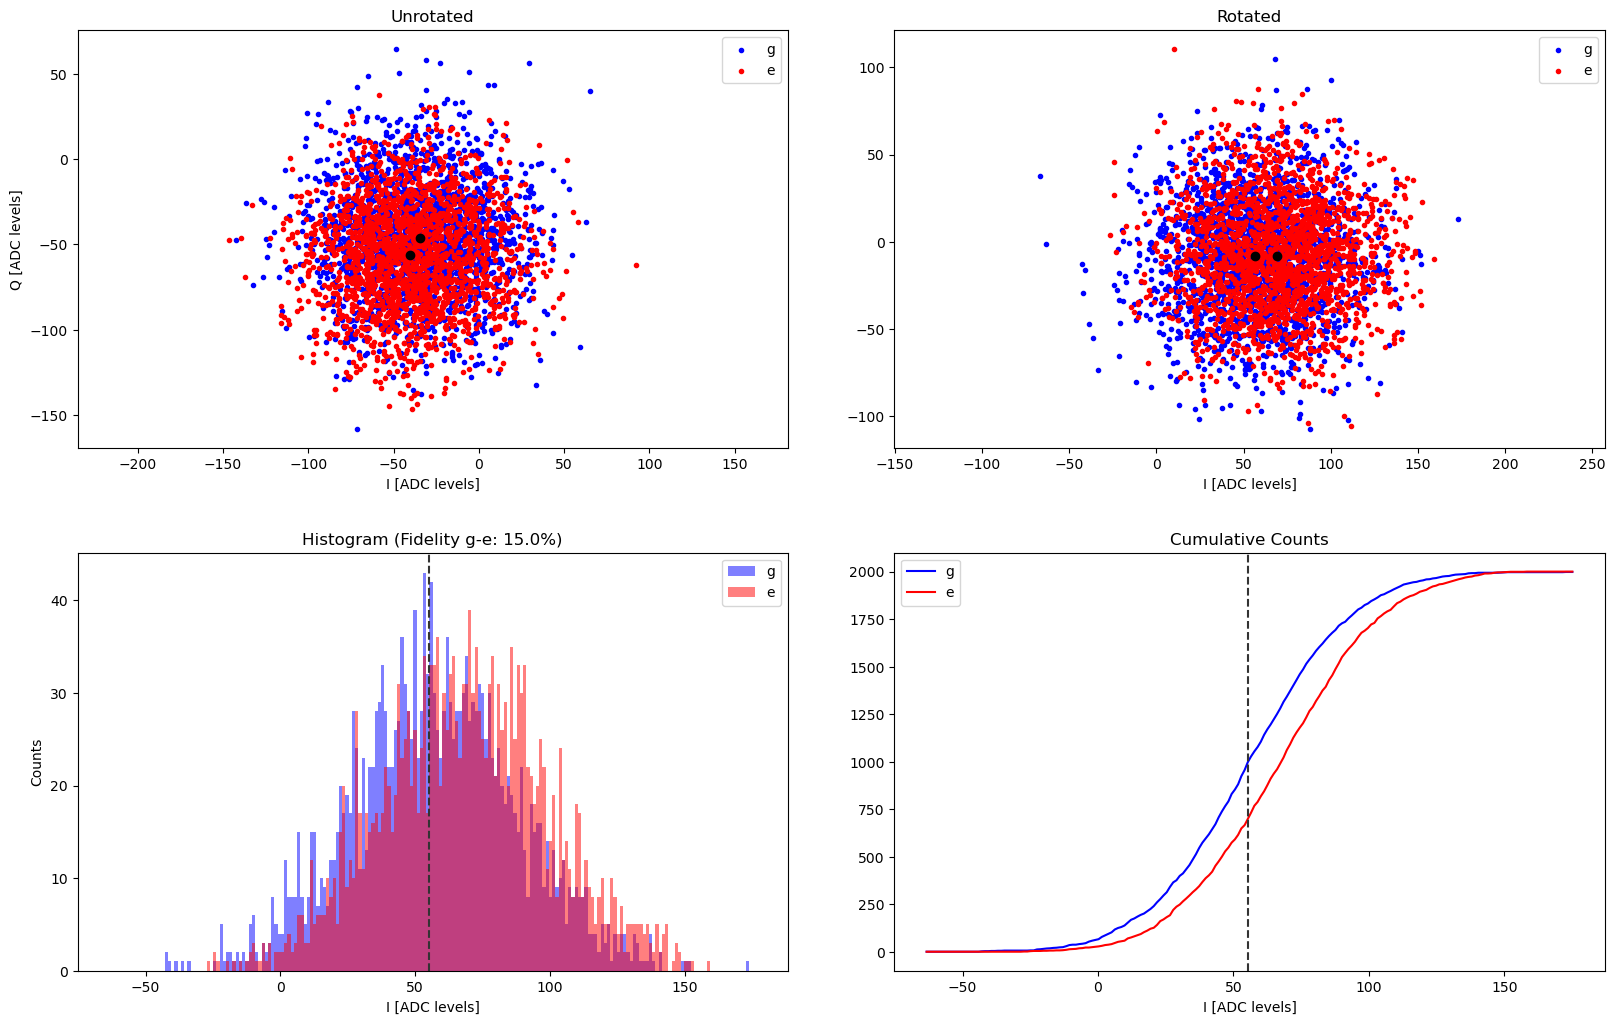

Qubit  (3)


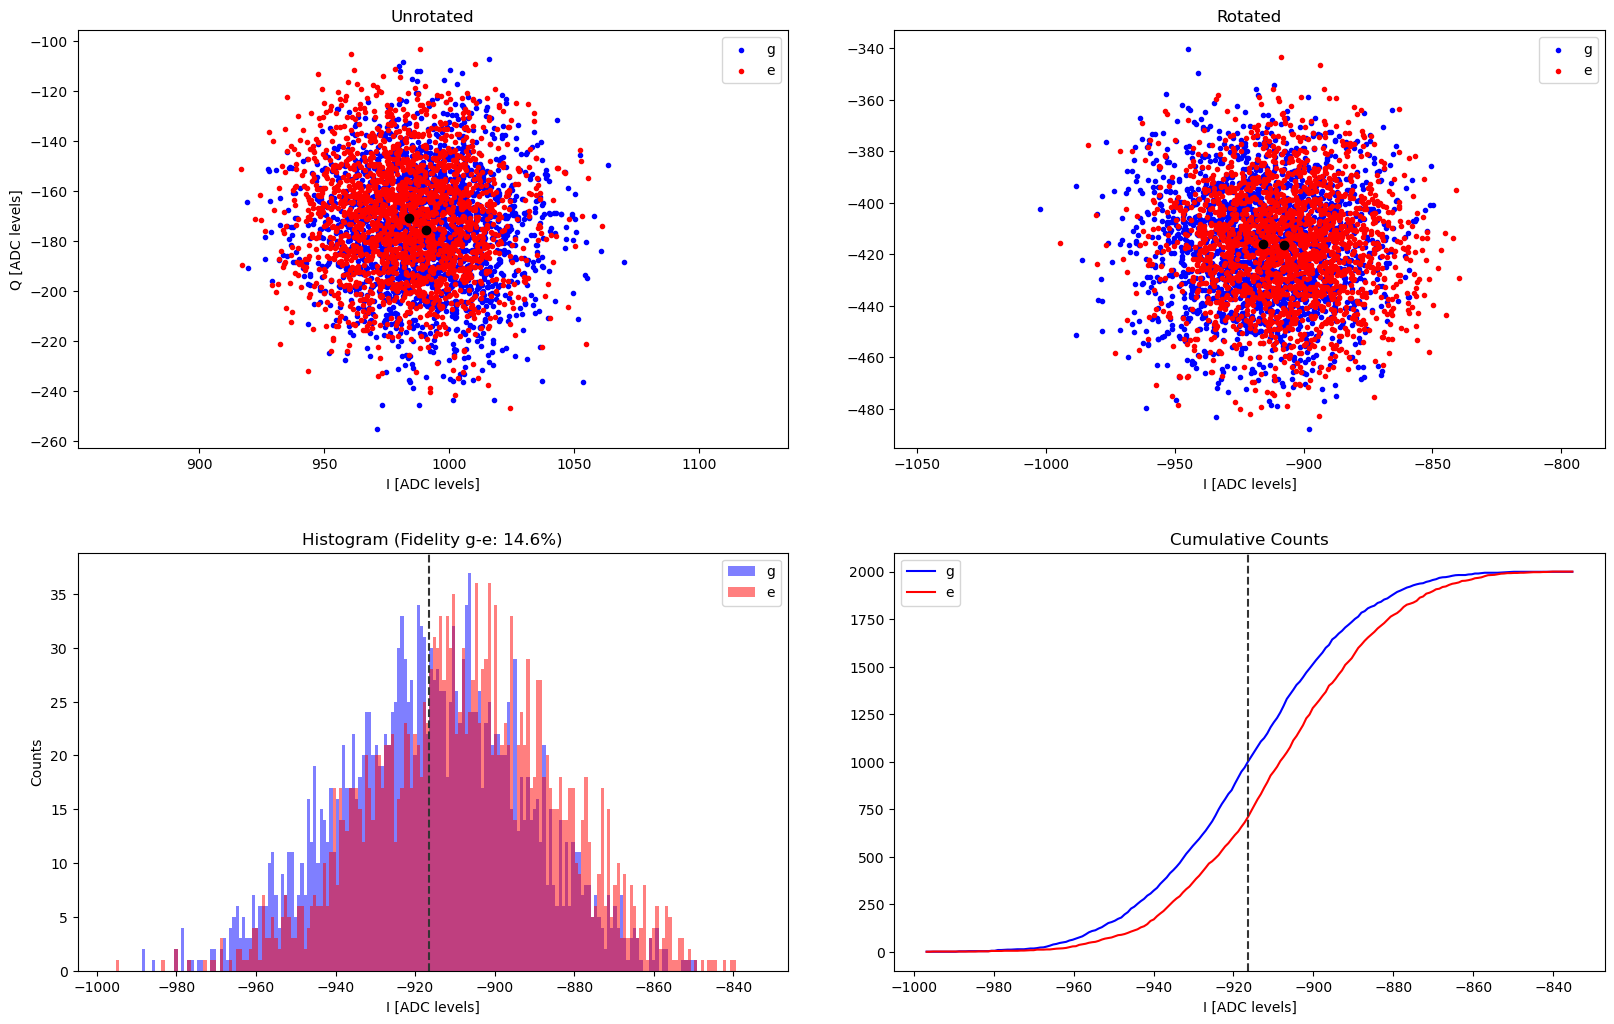

thresholds [0, 0, 55.32072197711133, -916.395199852806]
angles [0, 0, 118.62131781670035, -145.46579704472268]


  0%|          | 0/9 [00:00<?, ?it/s]

AssertionError: 

In [783]:
tomoExpt = meas.EgGfStateTomographyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"EgGf_state_tomo_{qubits[0]}{qubits[1]}",
    config_file=config_path,
)

tomoExpt.cfg.expt = dict(
    reps=2000, # reps per measurement basis
    tomo_qubits=qubits,
)

# print(tomoExpt.cfg)
tomoExpt.go(analyze=False, display=False, progress=True, save=False)

In [ ]:
tomo = tomoExpt
# tomo = qramExpt

# data, attrs = prev_data(expt_path, '00000_qram_protocol.h5')
# pulse_dict = attrs['pulse_dict']
# assert np.all(np.array(attrs['meas_order']) == meas_order)
# assert np.all(np.array(attrs['calib_order']) == calib_order)

data = tomo.data
pulse_dict = tomo.pulse_dict
assert np.all(np.array(tomo.meas_order) == meas_order)
assert np.all(np.array(tomo.calib_order) == calib_order)

n_tomo_raw = np.array(data['counts_tomo'])
n_calib = np.array(data['counts_calib'])

rint('Tomography counts')
print(n_tomo_raw)
print('Confusion matrix counts')
print(n_calib)
print('Confusion matrix corrected tomo matrix will be')
print(correct_readout_err(n_tomo_raw, n_calib))
print('Negative counts corrected tomo matrix will be')
print(fix_neg_counts(correct_readout_err(n_tomo_raw, n_calib)))

n_tomo = fix_neg_counts(correct_readout_err(n_tomo_raw, n_calib))

Tomography counts
[[5442 5714 4367 4477]
 [5131 5903 4252 4714]
 [5325 5723 4271 4681]
 [5169 4787 5143 4901]
 [4641 5283 4657 5419]
 [4678 5226 4771 5325]
 [4894 4986 4947 5173]
 [4593 5436 4581 5390]
 [4575 5376 4653 5396]]
Confusion matrix counts
[[10526  9954  7481  7039]
 [ 8088 12464  5702  8746]
 [ 8362  6722 10929  8987]
 [ 6369  8994  7963 11674]]
Confusion matrix corrected tomo matrix will be
[[11563.89215  4812.48222  3384.96909   238.65654]
 [ 7196.99909  8328.89466  3998.84841   475.25785]
 [12265.43173  3274.3903   1193.63943  3266.53854]
 [ 9754.00677 -1269.53469  7611.6026   3903.92532]
 [ 5281.46327  2742.09845  4207.87252  7768.56576]
 [ 4286.34494  3691.03841  6114.78628  5907.83037]
 [ 7327.57002   539.18649  6283.20614  5850.03735]
 [ 3484.64406  5261.56047  4939.64486  6314.15061]
 [ 2890.81345  5365.80496  5772.23772  5971.14387]]
Negative counts corrected tomo matrix will be
[[11564.  4812.  3385.   239.]
 [ 7197.  8329.  3999.   475.]
 [12265.  3274.  1194.  32

### Qram experiment

In [546]:
tomo_qubits = [2, 3] # which qubit/resonator we want to probe

In [736]:
n_tomo_raw_rounds = []
n_calib_rounds = []
n_tomo_rounds = []

qramExpts = []

In [731]:
save_data = True

  0%|          | 0/1 [00:00<?, ?it/s]

time step size [cycles]: 875
timesteps [2.5]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (2)


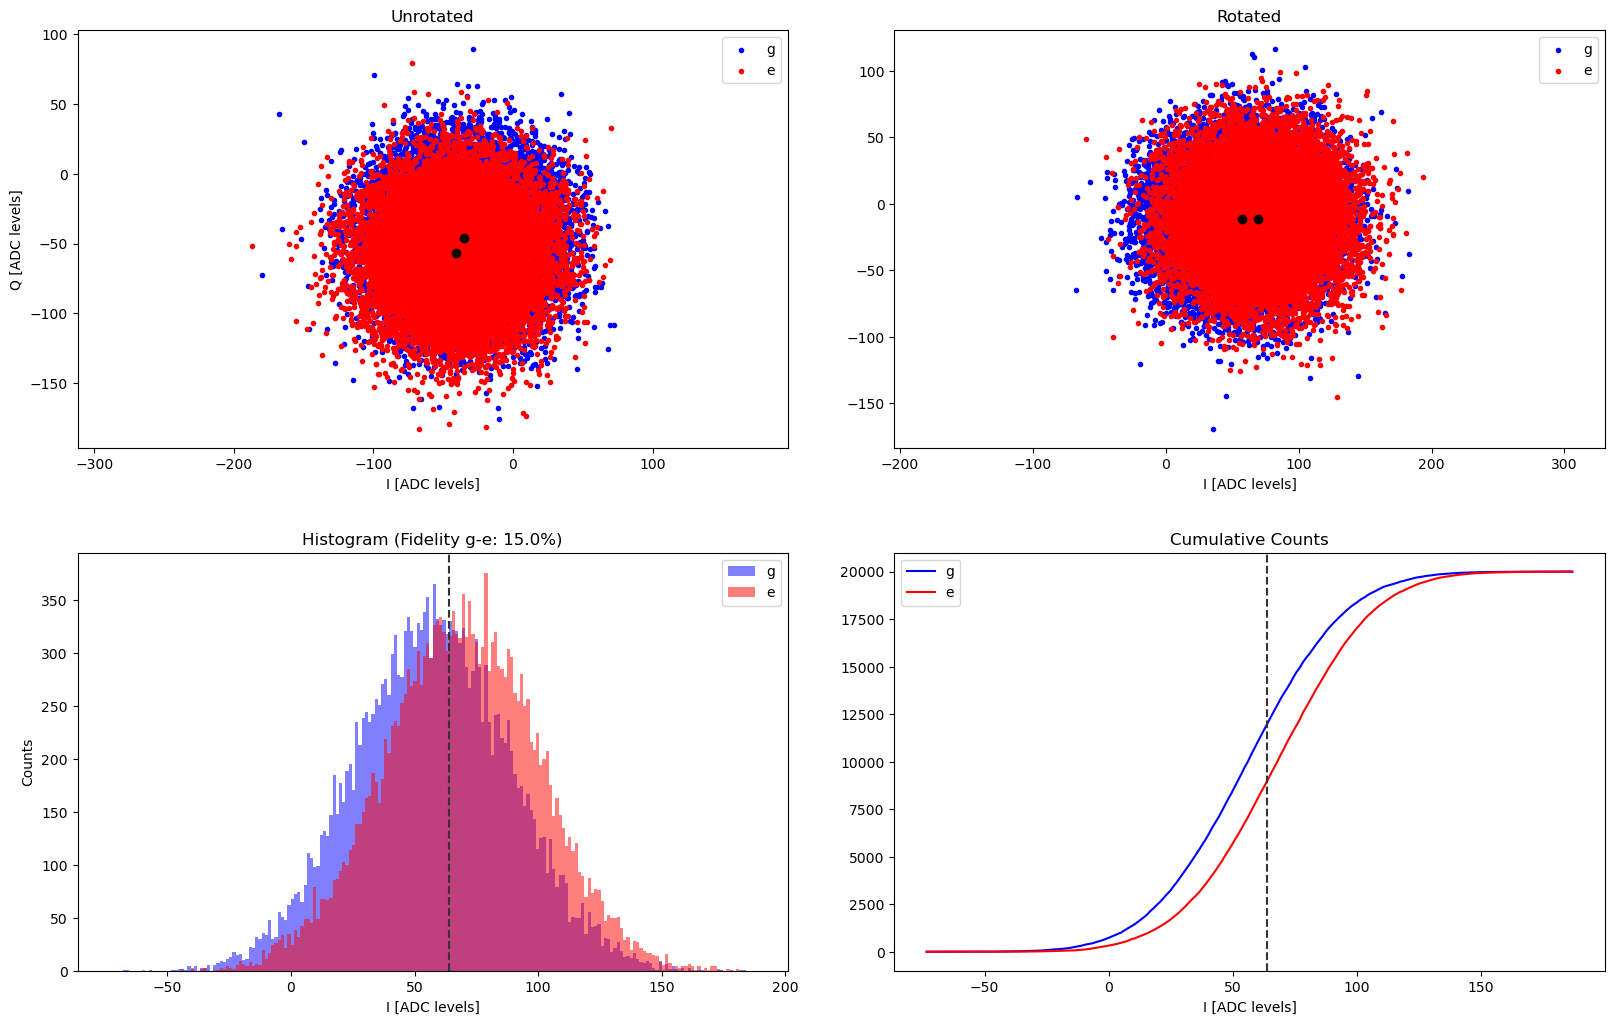

ge fidelity (%): 15.01537538438461 	 angle (deg): 116.24599376671173 	 threshold ge: 63.868126016883025
Qubit  (3)


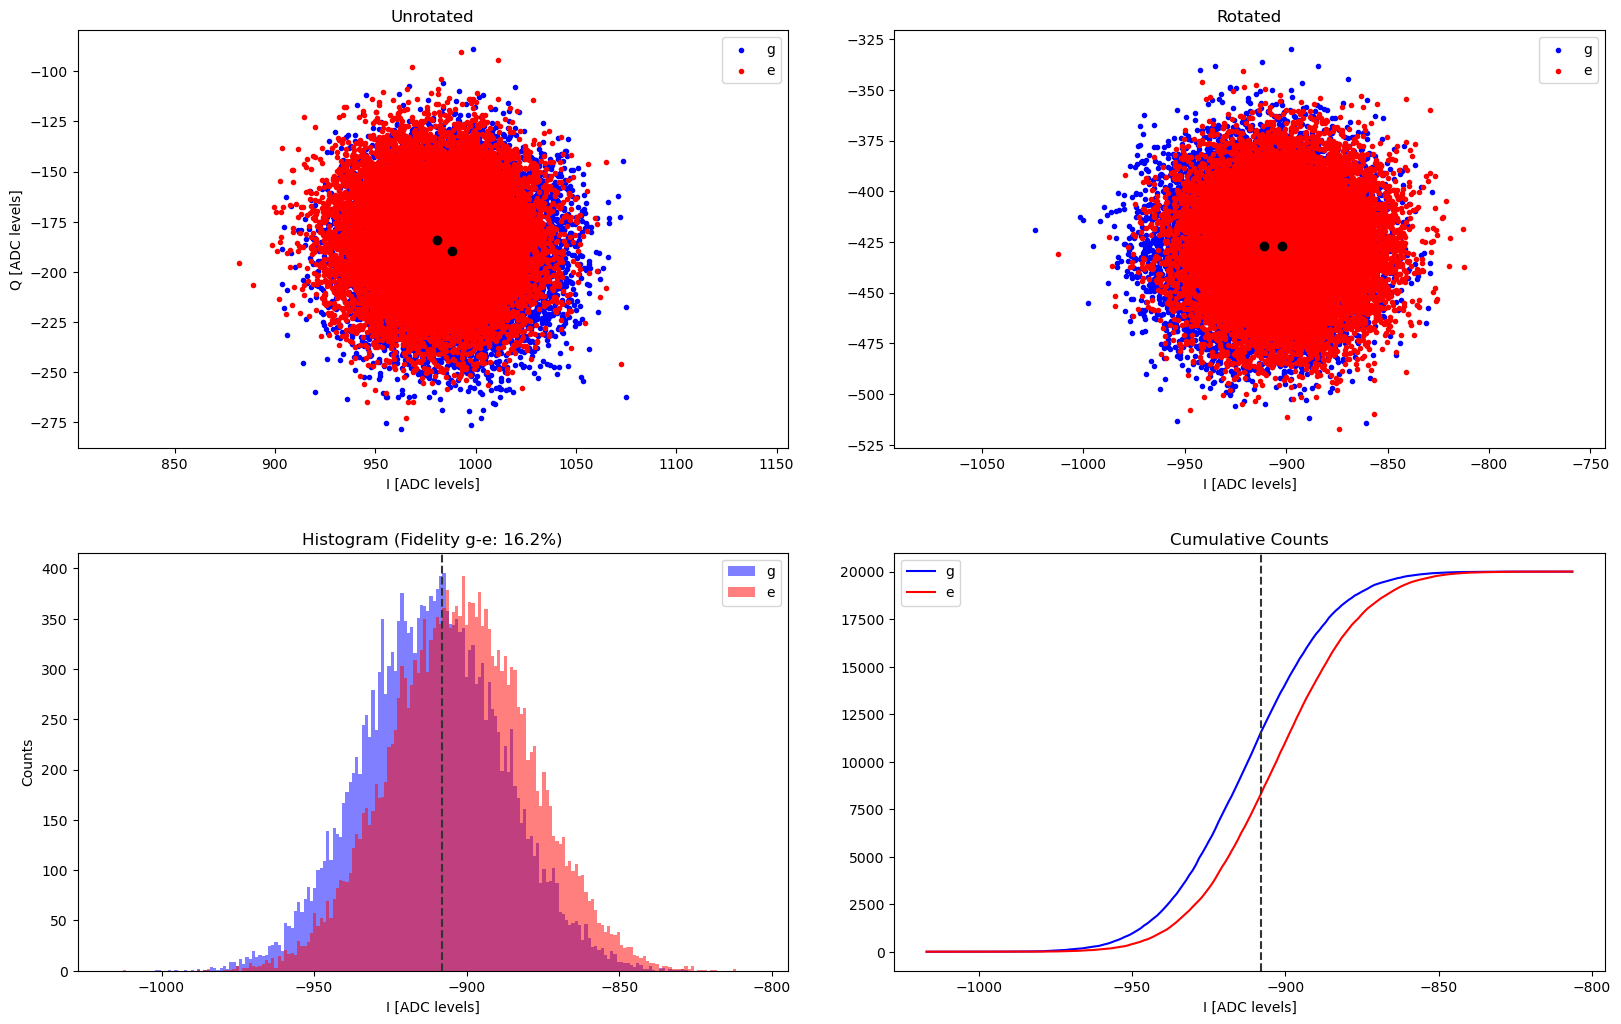

ge fidelity (%): 16.210405260131502 	 angle (deg): -144.03948280335524 	 threshold ge: -907.9759119935322
thresholds=[0, 0, 63.868126016883025, -907.9759119935322]
angles=[0, 0, 116.24599376671173, -144.03948280335524]
ge_avgs=[array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), [-35.430656310995445, -46.41323337670787, -40.67581297983084, -56.83611541964866], [988.2733680930687, -189.4253368206964, 980.6344759518387, -184.1464679303612]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 1/1 [01:24<00:00, 84.80s/it]

Saving s:\Connie\experiments\qramLL_4QR2\data\data_221215\00113_qram_protocol.h5


In [788]:
nrepeat = 30
nrepeat = 1

for i in tqdm(range(nrepeat)):
    qramExpt = meas.QramProtocolExperiment(
        soccfg=soc,
        path=expt_path,
        config_file=config_path,
    )

    span = 2.5 # total time [us]
    npts = 1
    # span = 1.8 # total time [us]
    # npts = 120
    # span = 0.8 # total time [us]
    # npts = 10
    print('time step size [cycles]:', soc.us2cycles(span/npts))

    qramExpt.cfg.expt = dict(
        # start=0, # start protocol time [us],
        # step=span/npts, # time step [us], 
        # expts=npts+1, # number of different time experiments - added 1 to include 0 step and full span
        start=span,
        step=0,
        expts=1, # number of different time experiments
        reps=7000, # number of reps per time step,
        singleshot_reps=20000, # reps per state for singleshot calibration
        post_process='scale', # 'threshold', (uses single shot binning), 'scale' (scale by ge_avgs), or None
        # thresholds=[48.765112894093534, 96.26256512031452, 332.5698328167488, 907.1402810621812],
        # ge_avgs=None, # (optional) don't rerun singleshot and instead use this
        # angles=[54.85719696454403, -4.061056979857183, 77.35730820785261, -80.28753842272687]
        tomo_2q=True, # True/False whether to do 2q state tomography on state at last time step
        tomo_qubits=tomo_qubits, # the qubits on which to do the 2q state tomo
        init_state='|0>(|0>+|1>)',
    )

    # qramExpt.cfg.device.readout.relax_delay = [10, 10, 10, 10] # Wait time between experiments [us]

    # print(qramExpt.cfg)

    import Pyro4.util
    try:
        qramExpt.go(analyze=False, display=False, progress=nrepeat<2, save=False)
    except Exception:
        print("Pyro traceback:")
        print("".join(Pyro4.util.getPyroTraceback()))

    tomo = qramExpt
    data = tomo.data
    n_tomo_raw = np.array(data['counts_tomo'])
    n_calib = np.array(data['counts_calib'])

    n_tomo_raw_rounds.append(n_tomo_raw)
    n_calib_rounds.append(n_calib)
    n_tomo_rounds.append(fix_neg_counts(correct_readout_err(n_tomo_raw, n_calib)))

    qramExpts.append(qramExpt)
    if save_data: qramExpt.save_data()

In [ ]:
style.use('default')
qramExpt.analyze()
qramExpt.display(err=False)

In [789]:
n_tomo_raw_rounds = []
n_calib_rounds = []
n_tomo_rounds = []
for qramExpt in qramExpts:
    tomo = qramExpt
    data = tomo.data
    n_tomo_raw = np.array(data['counts_tomo'])
    n_calib = np.array(data['counts_calib'])

    # print('Tomography counts')
    # print(n_tomo_raw)
    # print('Confusion matrix counts')
    # print(n_calib)
    # print('Confusion matrix corrected tomo matrix will be')
    # print(correct_readout_err(n_tomo_raw, n_calib))
    # print('Negative counts corrected tomo matrix will be')
    # print(fix_neg_counts(correct_readout_err(n_tomo_raw, n_calib)))

    n_tomo_raw_rounds.append(n_tomo_raw)
    n_calib_rounds.append(n_calib)
    n_tomo_rounds.append(fix_neg_counts(correct_readout_err(n_tomo_raw, n_calib)))

pulse_dict = qramExpts[-1].pulse_dict

In [790]:
n_tomo_raw = np.average(n_tomo_raw_rounds, axis=0)
n_tomo_raw_std = np.std(n_tomo_raw_rounds, axis=0)
n_calib = np.average(n_calib_rounds, axis=0)
n_calib_std = np.std(n_calib_rounds, axis=0)
n_tomo_avg = np.average(n_tomo_rounds, axis=0)
n_tomo_std = np.std(n_tomo_rounds, axis=0)
n_tomo_corrected = fix_neg_counts(correct_readout_err(n_tomo_raw, n_calib))
print(len(n_tomo_raw_rounds))

print('Average raw tomography counts')
print(n_tomo_raw)
print('Std raw tomography counts')
print(n_tomo_raw_std)
print('Average confusion matrix counts')
print(n_calib)
print('Std confusion matrix counts')
print(n_calib_std)
print('Average n_tomo')
print(n_tomo_avg)
print('Std n_tomo')
print(n_tomo_std)
print('Corrected average tomo with average calib counts, corrected for neg counts')
print(n_tomo_corrected)

# n_tomo = n_tomo_avg
n_tomo = n_tomo_corrected

31
Average raw tomography counts
[[2286.12903226 1563.61290323 1867.32258065 1282.93548387]
 [1968.48387097 1882.41935484 1608.         1541.09677419]
 [1965.09677419 1879.77419355 1595.83870968 1559.29032258]
 [1916.93548387 1334.93548387 2207.90322581 1540.22580645]
 [1667.06451613 1596.48387097 1905.64516129 1830.80645161]
 [1678.25806452 1599.90322581 1899.90322581 1821.93548387]
 [1926.22580645 1340.25806452 2211.5483871  1521.96774194]
 [1691.32258065 1592.35483871 1907.35483871 1808.96774194]
 [1683.51612903 1595.25806452 1909.35483871 1811.87096774]]
Std raw tomography counts
[[252.16465971 189.78726247 191.76554689 199.6681013 ]
 [231.45331459 205.10009739 177.40567689 196.27948389]
 [260.40246206 198.64309211 171.67844977 227.15707136]
 [256.60147782 195.44984267 220.48236779 255.08110155]
 [226.95714182 186.11024672 225.77573063 256.66225068]
 [227.29403548 190.1914748  225.14702792 252.78295363]
 [241.70332517 197.38140053 229.74794586 221.17056385]
 [230.79042121 185.90763

In [936]:
n_tomo = np.array( # |0>(|0+1>)
[[7000,    0,    0,    0.],
 [3792, 3073,  136,    0.],
 [3970, 2784,    0,  247.],
 [2472,    0, 4528,    0.],
 [1411, 1199, 2044, 2346.],
 [1533, 1196, 1949, 2322.],
 [2195,    0, 4805,    0.],
 [1624, 1141, 1970, 2265.],
 [1549, 1185, 2072, 2193.]]
)
 
# n_tomo = np.array( # |1>(|0+1>)
# [[ 971, 2621, 3408,    0.],
#  [1845, 2063, 1577, 1515.],
#  [1916, 1949, 1368, 1767.],
#  [2170,  999, 2005, 1825.],
#  [1757, 1430, 1434, 2378.],
#  [1457, 1758, 1643, 2142.],
#  [2217, 1055, 1985, 1743.],
#  [1738, 1478, 1332, 2453.],
#  [1841, 1476, 1305, 2378.]]
# )

n_tomo = np.array( # (|0+1>)(|0+1>)
[[3569, 1651, 1780,    0.],
 [2896, 2730,  880,  495.],
 [2897, 2727,  773,  603.],
 [2200,  737, 3594,  470.],
 [1630, 1303, 2016, 2051.],
 [1626, 1360, 1906, 2108.],
 [2408,  460, 3146,  987.],
 [1430, 1641, 2026, 1904.],
 [1478, 1387, 1767, 2368.]]
)

n_tomo = np.array( # (|0+i1>)(|0+1>)
[[3163., 2173., 1664.,    0.],
 [2438., 3299.,  806.,  456.],
 [2627., 3226.,  722.,  425.],
 [1857., 1092., 3028., 1023.],
 [1242., 1632., 1695., 2431.],
 [1469., 1365., 1518., 2647.],
 [1980.,  885., 2896., 1239.],
 [1300., 1627., 1468., 2605.],
 [ 963., 1985., 1752., 2300.]])


## Run analysis

Get ideal psi for fidelity calculation. Change this depending on what you want for ideal final state.

In [806]:
# psi_id = qt.tensor(1/np.sqrt(2)*(psiZ[0]+psiZ[1]), 1/np.sqrt(2)*(psiZ[0]-1j*psiZ[1]))
psi_id = qt.tensor(psiZ[1], 1/np.sqrt(2)*(psiZ[0]-1j*psiZ[1]))
# psi_id = qt.tensor(psiZ[1], 1/np.sqrt(2)*(psiZ[0]+1*psiZ[1]))
# psi_id = qt.tensor(psiZ[1], 1/np.sqrt(2)*(psiZ[0]+psiZ[1]))
# psi_id = qt.tensor(0.5*psiZ[0], psiZ[0]) + qt.tensor(-0.5*psiZ[0], psiZ[1]) + qt.tensor((0.43+0.25j)*psiZ[1], psiZ[0]) + qt.tensor((0.25-0.43j)*psiZ[1], psiZ[1])
# psi_id = qt.tensor(1/np.sqrt(2)*(psiZ[0]-1j*psiZ[1]), 1/np.sqrt(2)*(psiZ[0]-1j*psiZ[1]))

# psi_id = qt.tensor(psiZ[1], psiZ[1])
# psi_id = qt.tensor(psiZ[0], psiZ[0])

rho_id = qt.ket2dm(psi_id)
# rho_id = rho_id.full()
print(rho_id)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0. +0.j  0. +0.j  0. +0.j  0. +0.j ]
 [0. +0.j  0. +0.j  0. +0.j  0. +0.j ]
 [0. +0.j  0. +0.j  0.5+0.j  0. +0.5j]
 [0. +0.j  0. +0.j  0. -0.5j 0.5+0.j ]]


In [937]:
id2q = qt.tensor(qt.qeye(2), qt.qeye(2))

rho_id = qt.Qobj(inpt=np.array( # forward + backward simulation smaller amps, averaged pi pulses, q0/q1
[[ 0.00787193+0.j,         -0.00720047+0.00645315j,  0.01727982+0.03581838j,
   0.00949751-0.03950817j],
 [-0.00720047-0.00645315j,  0.01747295+0.j,          0.01687327-0.02555221j,
  -0.03385929+0.01029621j],
 [ 0.01727982-0.03581838j,  0.01687327+0.02555221j,  0.49433755+0.j,
  -0.4008212 -0.27388886j],
 [ 0.00949751+0.03950817j, -0.03385929-0.01029621j, -0.4008212 +0.27388886j,
   0.48031758+0.j        ]]),
                 dims=id2q.dims, shape=id2q.shape)


rho_id = qt.Qobj(inpt=np.array( # forward + backward simulation using non-averaged pi pulses, q0/q1
[[0.00552111+0.j,         0.01432954-0.00841523j, 0.01722886-0.00601645j,
  0.00812916+0.02449028j],
 [0.01432954+0.00841523j, 0.18945162+0.j,         0.01511418-0.00217467j,
  0.01024223+0.01364156j],
 [0.01722886+0.00601645j, 0.01511418+0.00217467j, 0.26402757+0.j,
  0.02488624+0.37598589j],
 [0.00812916-0.02449028j, 0.01024223-0.01364156j, 0.02488624-0.37598589j,
  0.5409997 +0.j        ]]),
                 dims=id2q.dims, shape=id2q.shape)

rho_id = qt.Qobj(inpt=np.array( # |0>|0+1> input, forward simulation smaller amps, averaged pi pulses, q2/q3
[[ 9.94334173e-01+0.00000000e+00j,  2.95488839e-03+2.64962413e-02j,
  -3.99682679e-02+3.78054489e-03j, -6.56741155e-04-6.61718964e-04j],
 [ 2.95488839e-03-2.64962413e-02j,  2.86287490e-03+0.00000000e+00j,
   1.53294276e-03+7.60564506e-04j,  4.58698399e-05+2.23372708e-05j],
 [-3.99682679e-02-3.78054489e-03j,  1.53294276e-03-7.60564506e-04j,
   2.80004978e-03+0.00000000e+00j,  7.02786998e-05+4.37663736e-05j],
 [-6.56741155e-04+6.61718964e-04j,  4.58698399e-05-2.23372708e-05j,
   7.02786998e-05-4.37663736e-05j,  2.90278805e-06+0.00000000e+00j]]),
                 dims=id2q.dims, shape=id2q.shape)

# rho_id = qt.Qobj(inpt=np.array( # |1>|0+1> input, forward simulation smaller amps, averaged pi pulses, q2/q3
# [[ 6.30272256e-02+0.00000000e+00j,  2.02946900e-02+2.76402139e-02j,
#   -1.96837547e-02+8.29659990e-03j, -2.15192460e-04-3.58489581e-05j],
#  [ 2.02946900e-02-2.76402139e-02j,  4.26222189e-01+0.00000000e+00j,
#   -9.15029392e-02-5.01411402e-02j, -4.04704543e-03+6.35455759e-03j],
#  [-1.96837547e-02-8.29659990e-03j, -9.15029392e-02+5.01411402e-02j,
#    5.10374465e-01+0.00000000e+00j, -9.46955041e-03-6.87960001e-03j],
#  [-2.15192460e-04+3.58489581e-05j, -4.04704543e-03-6.35455759e-03j,
#   -9.46955041e-03+6.87960001e-03j,  3.76120587e-04+0.00000000e+00j]]),
#                  dims=id2q.dims, shape=id2q.shape)

rho_id = qt.Qobj(inpt=np.array( # |0+1>|0+1> input, forward simulation smaller amps, averaged pi pulses, q2/q3
[[ 5.18774999e-01+0.j,         -2.46814180e-02-0.18874534j,
  -2.80544335e-01-0.04851654j,  6.55811582e-03+0.00571786j],
 [-2.46814180e-02+0.18874534j,  1.89900156e-01+0.j,
  -3.85029976e-02-0.01667125j, -1.88443617e-03+0.00303838j],
 [-2.80544335e-01+0.04851654j, -3.85029976e-02+0.01667125j,
   2.91154953e-01+0.j,         -4.39699964e-03-0.00368626j],
 [ 6.55811582e-03-0.00571786j, -1.88443617e-03-0.00303838j,
  -4.39699964e-03+0.00368626j,  1.69891665e-04+0.j        ]]),
                 dims=id2q.dims, shape=id2q.shape)

rho_id = qt.Qobj(inpt=np.array( # |0+i1>|0+1> input, forward simulation smaller amps, averaged pi pulses, q2/q3
[[ 5.34049918e-01+0.j,         -2.04750116e-01+0.0611259j,
  -8.59022996e-02+0.25596306j,  5.60009806e-03-0.00742929j],
 [-2.04750116e-01-0.0611259j,   1.96166943e-01+0.j,
  -3.44181418e-02-0.03603372j, -2.42826815e-03+0.00296604j],
 [-8.59022996e-02-0.25596306j, -3.44181418e-02+0.03603372j,
   2.69599718e-01+0.j,         -5.12968975e-03-0.0026015j ],
 [ 5.60009806e-03+0.00742929j, -2.42826815e-03-0.00296604j,
  -5.12968975e-03+0.0026015j,   1.83420731e-04+0.j        ]]),
                 dims=id2q.dims, shape=id2q.shape)

Generate test data

In [863]:
# n_tomo = generate_counts(rho_id=rho_id, n_tot=8000, noise=None)
n_tomo = generate_counts(rho_id=rho_id, n_tot=8000, evol_mats=evol_mats, noise=None)
n_calib = qt.qeye(4).full()
print(fix_neg_counts(n_tomo))

# n_tomo = generate_counts(rho_id=rho_id, n_tot=8000, noise=None)
# print(fix_neg_counts(n_tomo))

# n_tomo = [[2000, 2000, 2000, 2000.] ,
#  [2001, 1999, 3411,  589.] ,
#  [4005,    0, 3398,  602.] ,
#  [4010, 2179,    0, 1822.] ,
#  [4068, 2127,  802, 1019.] ,
#  [5895,  302,  806, 1016.] ,
#  [2008,  191, 1992, 3808.] ,
#  [ 649, 1552, 3754, 2043.] ,
#  [1523,  678,  233, 5564.]]

# n_tomo = [[   0,    0, 4000, 4000.],
#  [   0,    0, 6796, 1204.],
#  [   0,    0, 1179, 6821.],
#  [2004, 1167, 1996, 2833.],
#  [2048, 1126,  180, 4646.],
#  [ 127, 3046, 3258, 1568.],
#  [2005, 1167, 1995, 2833.],
#  [2048, 1127,  180, 4646.],
#  [ 127, 3046, 3258, 1568.],]

# n_tomo= [[2000, 2000., 2000., 2000.],
#  [2001, 1999., 2000., 2000.],
#  [4005,    0., 4000.,    0.],
#  [4010, 4002.,    0.,    0.],
#  [4012, 4005.,    0.,    0.],
#  [8021,    0.,    0.,    0.],
#  [2008, 2002., 1992., 1998.],
#  [2008, 2005., 1996., 1991.],
#  [4015,    0., 3987.,    0.],]


# n_tomo = np.array(
#     [[4978, 5022,    0,    0.],
#      [4807, 5193,    0,    0.],
#      [5002, 4998,    0,    0.],
#      [3880, 4899, 1221,    0.],
#      [4802, 4279,  919,    0.],
#      [5028, 4187,  727,   57.],
#      [4068, 5093,  839,    0.],
#      [4688, 4689,  622,    0.],
#      [4927, 4741,  332,    0.]]
# )


Generating with evol mats
[[ 565. 3610. 3819.    7.]
 [2330. 1845. 1971. 1855.]
 [1889. 2285. 2063. 1762.]
 [2313. 1914. 2072. 1702.]
 [2598. 1627. 1788. 1989.]
 [1909. 2315. 2176. 1600.]
 [2380. 1863. 2005. 1753.]
 [2396. 1845. 1565. 2196.]
 [2476. 1765. 1630. 2130.]]


##### Run MLE without ZZ correction

Convergence: True
Fidelity (no ZZ correction): 0.9474451328592026
Purity (no ZZ correction): 0.40877172150010666
[[ 0.15 +0.j    -0.029+0.015j  0.007-0.014j -0.001-0.029j]
 [-0.029-0.015j  0.388+0.j     0.097-0.041j -0.046+0.042j]
 [ 0.007+0.014j  0.097+0.041j  0.447+0.j    -0.01 +0.029j]
 [-0.001+0.029j -0.046-0.042j -0.01 -0.029j  0.015+0.j   ]]


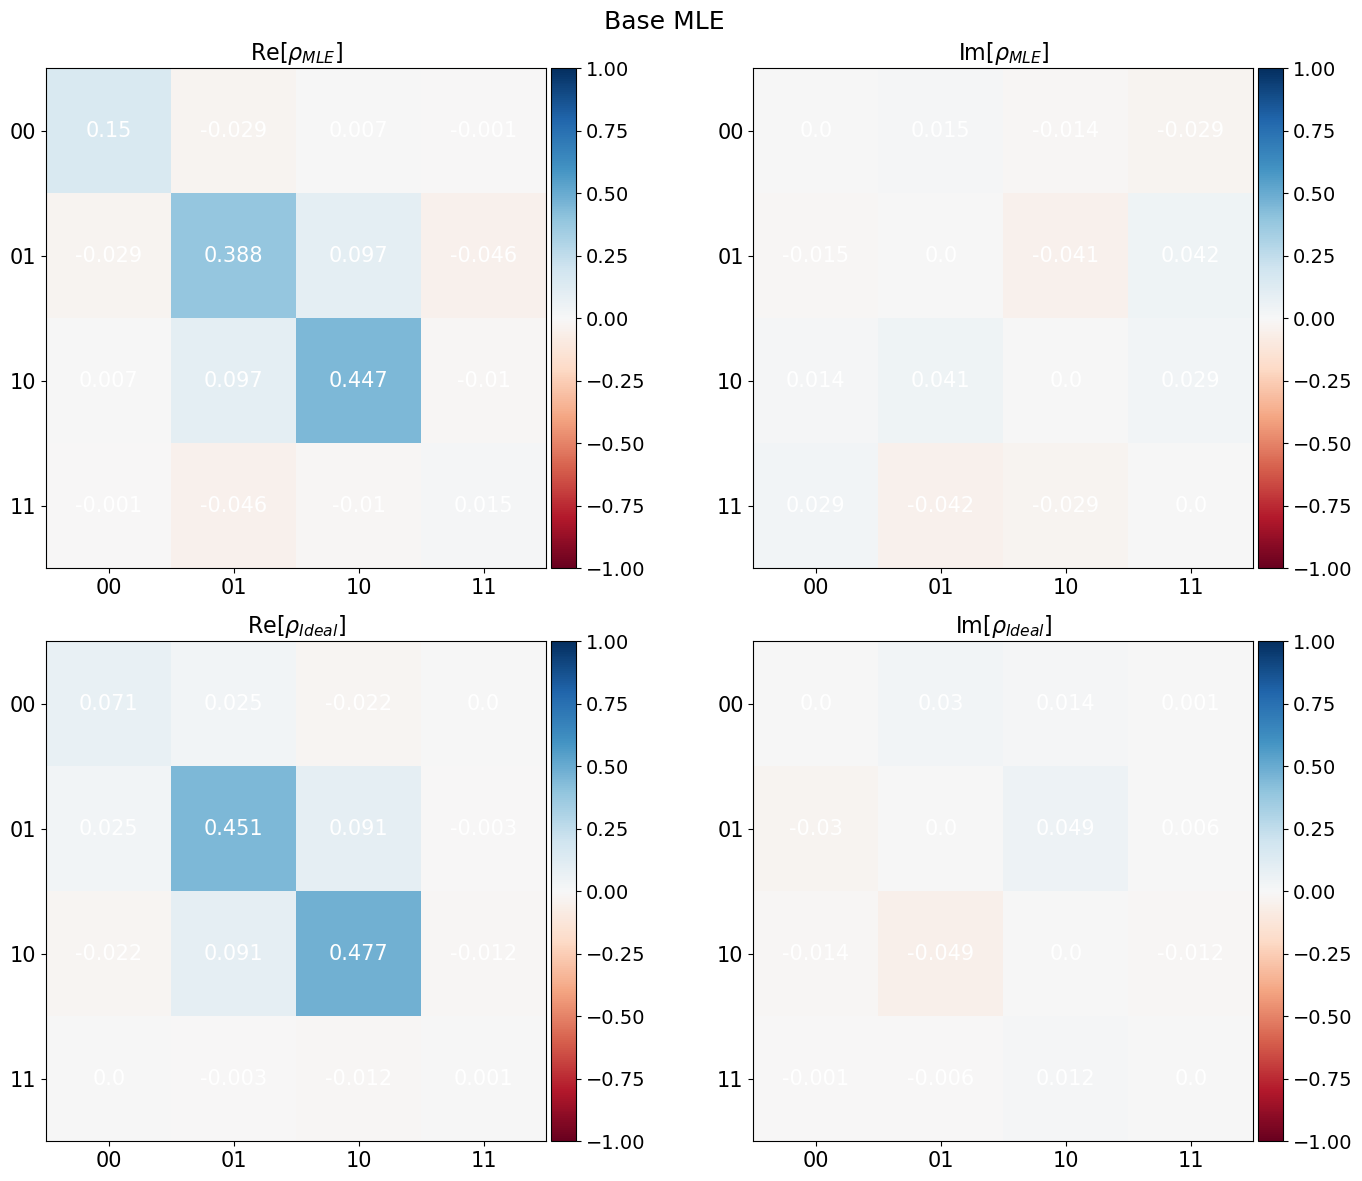

In [886]:
# methods = 'Nelder-Mead' 'Powell' 'CG' 'BFGS' 'Newton-CG' 'L-BFGS-B' 'TNC' 'COBYLA' 'SLSQP' 'dogleg' 'trust-ncg'
rho_MLE_base = run_MLE(n=n_tomo, rho_id=rho_id, ZZ_correction=False, method='L-BFGS-B')
# rho_MLE_base = run_MLE(n=fix_neg_counts(correct_readout_err(n_tomo, n_calib)), rho_id=rho_id, ZZ_correction=False, method='L-BFGS-B')
# print(rho_MLE_base)

fid_base = qt.fidelity(qt.Qobj(rho_MLE_base, dims=rho_id.dims), rho_id)**2 # qutip uses N&C fidelity which is "sqrt fidelity"
purity_base = np.real(np.trace(rho_MLE_base @ rho_MLE_base))
print(f'Fidelity (no ZZ correction): {fid_base}')
print(f'Purity (no ZZ correction): {purity_base}')
print(np.around(rho_MLE_base, decimals=3))
show_plot_rho_2d(rho_MLE_base, rho_id, title='Base MLE', cmax=1.0)

#### Run MLE with ZZ

Get evol mats for ZZ

In [742]:
import yaml
with open(config_path, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

In [457]:
evol_mats_01 = {'XX': array([[ 0.50118903+0.00006481j,  0.5823486 +0.12326867j,
          0.5010638 +0.00090354j,  0.11545053-0.36419232j],
        [-0.24102118+0.43883635j,  0.38834345-0.45115441j,
         -0.24169539+0.43832344j, -0.2636837 -0.2764915j ],
        [-0.256926  -0.46067075j, -0.19575595+0.30046964j,
          0.25623251+0.46120773j, -0.43634967-0.34952088j],
        [ 0.32800565-0.3351489j ,  0.38654167+0.11535661j,
         -0.32863824+0.33469298j, -0.23789756+0.58214891j]]),
 'XY': array([[ 0.50109863+0.00013734j,  0.12330481-0.58245054j,
          0.50097329+0.0009759j , -0.36425513-0.11548003j],
        [-0.43892099-0.24105408j,  0.38820809-0.45112937j,
         -0.438408  -0.24172843j, -0.26367621-0.27640345j],
        [-0.25682661-0.46071357j,  0.30047699+0.19576243j,
          0.25613303+0.46125039j, -0.34953217+0.43635996j],
        [ 0.33515948+0.3280132j ,  0.38655704+0.11527517j,
         -0.33470356-0.32864581j, -0.23777374+0.58218507j]]),
 'XZ': array([[ 0.70806575-0.0001362j ,  0.        +0.j        ,
          0.70787958+0.00104j   ,  0.        +0.j        ],
        [ 0.        +0.j        ,  0.04650335+0.84044909j,
          0.        +0.j        ,  0.53965744+0.02328762j],
        [-0.50093342+0.4977033j ,  0.        +0.j        ,
          0.5018767 -0.49701629j,  0.        +0.j        ],
        [ 0.        +0.j        , -0.39850857+0.36424398j,
          0.        +0.j        , -0.50430419-0.67372458j]]),
 'YX': array([[ 0.50116627+0.00004681j,  0.58233026+0.12328105j,
          0.00087404-0.50108662j, -0.36422467-0.11542786j],
        [-0.24099446+0.43882507j,  0.38834547-0.45113238j,
          0.43835761+0.24168054j, -0.2764872 +0.26372296j],
        [ 0.46070691-0.25691071j, -0.30047245-0.19579291j,
          0.25620411+0.46119589j, -0.43634777-0.3495001j ],
        [ 0.33514498+0.32804033j, -0.11539558+0.38655648j,
         -0.32863531+0.33466579j, -0.23787574+0.58214024j]]),
 'YY': array([[ 0.50107587+0.00011933j,  0.12331719-0.5824322j ,
          0.00094641-0.50099612j, -0.11545736+0.36428747j],
        [-0.43890971-0.24102737j,  0.38821012-0.45110735j,
         -0.24171358+0.43844218j, -0.27639914+0.26371547j],
        [ 0.46074972-0.25681132j, -0.19579939+0.3004798j ,
          0.25610464+0.46123855j, -0.34951139+0.43635806j],
        [-0.32804788+0.33515557j, -0.11531414+0.38657186j,
         -0.33467636-0.32864288j, -0.23775192+0.58217639j]]),
 'YZ': array([[ 0.70803284-0.00017038j,  0.        +0.j        ,
          0.00100708-0.70791255j,  0.        +0.j        ],
        [ 0.        +0.j        ,  0.04647942+0.84042191j,
          0.        +0.j        ,  0.02324536-0.53970368j],
        [-0.49770337-0.50097987j,  0.        +0.j        ,
          0.5018774 -0.49696869j,  0.        +0.j        ],
        [ 0.        +0.j        , -0.36424133-0.39857111j,
          0.        +0.j        , -0.50430516-0.67368828j]]),
 'ZX': array([[ 0.70765578+0.00017276j,  0.70745381+0.00062099j,
          0.        +0.j        ,  0.        +0.j        ],
        [ 0.39085837+0.58860258j, -0.39060898-0.58901048j,
          0.        +0.j        ,  0.        +0.j        ],
        [ 0.        +0.j        ,  0.        +0.j        ,
         -0.38043491+0.64327596j,  0.16815679+0.6428041j ],
        [ 0.        +0.j        ,  0.        +0.j        ,
         -0.44210182+0.49599526j, -0.04626105-0.74591293j]]),
 'ZY': array([[ 0.7077326 +0.00012394j,  0.00050518-0.70737705j,
          0.        +0.j        ,  0.        +0.j        ],
        [-0.58860232+0.39071967j, -0.39061069-0.58910164j,
          0.        +0.j        ,  0.        +0.j        ],
        [ 0.        +0.j        ,  0.        +0.j        ,
         -0.38037205+0.64333418j,  0.64277662-0.1681813j ],
        [ 0.        +0.j        ,  0.        +0.j        ,
         -0.49595968-0.4421111j , -0.04617871-0.74593618j]]),
 'ZZ': array([[ 1.        +0.j        ,  0.        +0.j        ,
          0.        +0.j        ,  0.        +0.j        ],
        [ 0.        +0.j        ,  0.48562782-0.87416567j,
          0.        +0.j        ,  0.        +0.j        ],
        [ 0.        +0.j        ,  0.        +0.j        ,
          0.60493172+0.79627735j,  0.        +0.j        ],
        [ 0.        +0.j        ,  0.        +0.j        ,
          0.        +0.j        , -0.67424614+0.7385067j ]])
}

In [458]:
evol_mats_21 = {'XX': array([[ 0.5015316 +0.00109924j,  0.4995491 +0.00526269j,
         0.50140444+0.00193827j,  0.49876165-0.02071716j],
       [ 0.49920007-0.02701218j, -0.5005494 +0.022898j  ,
         0.49912055-0.02617003j, -0.49829591+0.04887003j],
       [ 0.24149568-0.43785784j,  0.21840429-0.44855067j,
        -0.24227557+0.43756961j, -0.1949081 +0.45966676j],
       [ 0.21333919-0.45053437j, -0.19088433+0.4626165j ,
        -0.21413292+0.45029558j,  0.16667144-0.47229064j]]), 'XY': array([[ 0.50121219+0.00098944j,  0.00596817-0.49986089j,
         0.5010853 +0.00182797j, -0.02002938-0.49910945j],
       [ 0.02773108+0.49948093j, -0.50023532+0.02277449j,
         0.02688827+0.49940254j, -0.49798892+0.04873046j],
       [ 0.24124813-0.43763042j, -0.44853059-0.21917603j,
        -0.24202759+0.43734254j,  0.45968691+0.19568044j],
       [ 0.45112366+0.21284162j, -0.19086173+0.46228064j,
        -0.45088583-0.2136362j ,  0.16666635-0.47195381j]]), 'XZ': array([[ 0.70806575-0.0001362j ,  0.        +0.j        ,
         0.70787958+0.00104j   ,  0.        +0.j        ],
       [ 0.        +0.j        ,  0.17681986+0.68508898j,
         0.        +0.j        ,  0.21206299+0.67443004j],
       [-0.50093342+0.4977033j ,  0.        +0.j        ,
         0.5018767 -0.49701629j,  0.        +0.j        ],
       [ 0.        +0.j        , -0.62598126-0.32792572j,
         0.        +0.j        ,  0.64271187+0.29511838j]]), 'YX': array([[ 0.50150884+0.00108117j,  0.49952561+0.00524562j,
         0.00190881-0.50142737j, -0.02074874-0.49878406j],
       [ 0.49917641-0.02702889j, -0.50052491+0.02291377j,
        -0.02620063-0.49914171j,  0.04890292+0.49831657j],
       [ 0.43786368+0.24153242j,  0.4485586 +0.21844212j,
        -0.24228032+0.43754085j, -0.19491428+0.4596384j ],
       [ 0.45054245+0.21337539j, -0.46262679-0.19092172j,
        -0.21413942+0.45026725j,  0.16667938-0.47226263j]]), 'YY': array([[ 0.50118944+0.00097139j,  0.00595105-0.49983741j,
         0.00179852-0.5011082j , -0.49913192+0.02006096j],
       [ 0.02774776+0.49945723j, -0.50021085+0.02279026j,
         0.49942367-0.02691893j,  0.04876333+0.49800958j],
       [ 0.43763627+0.24128485j,  0.21921391-0.44853848j,
        -0.24203234+0.4373138j ,  0.45965852+0.19568659j],
       [-0.21287783+0.45113179j, -0.46229092-0.1908991j ,
        -0.45085749-0.21364274j,  0.16667428-0.47192581j]]), 'YZ': array([[ 0.70803284-0.00017038j,  0.        +0.j        ,
         0.00100708-0.70791255j,  0.        +0.j        ],
       [ 0.        +0.j        ,  0.17684269+0.68504724j,
         0.        +0.j        ,  0.6744528 -0.21210649j],
       [-0.49770337-0.50097987j,  0.        +0.j        ,
         0.5018774 -0.49696869j,  0.        +0.j        ],
       [ 0.        +0.j        ,  0.32797245-0.62599602j,
         0.        +0.j        ,  0.64266675+0.29513337j]]), 'ZX': array([[ 0.70834662+0.00169307j,  0.70605257+0.00059457j,
         0.        +0.j        ,  0.        +0.j        ],
       [ 0.29196827-0.64264821j, -0.29191542+0.64519362j,
         0.        +0.j        ,  0.        +0.j        ],
       [ 0.        +0.j        ,  0.        +0.j        ,
        -0.70805161+0.01703222j, -0.70561034+0.02211603j],
       [ 0.        +0.j        ,  0.        +0.j        ,
        -0.27118076+0.65179277j,  0.26729243-0.65588085j]]), 'ZY': array([[ 0.70791724+0.00148839j, -0.00035251-0.7064837j ,
         0.        +0.j        ,  0.        +0.j        ],
       [ 0.6426484 +0.29300852j, -0.29192381+0.64471788j,
         0.        +0.j        ,  0.        +0.j        ],
       [ 0.        +0.j        ,  0.        +0.j        ,
        -0.70761597+0.01722368j,  0.02307876+0.70601179j],
       [ 0.        +0.j        ,  0.        +0.j        ,
        -0.65182644-0.27222282j,  0.2673163 -0.65540577j]]), 'ZZ': array([[ 1.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ],
       [ 0.        +0.j        , -0.99869406+0.0510899j ,
         0.        +0.j        ,  0.        +0.j        ],
       [ 0.        +0.j        ,  0.        +0.j        ,
        -0.48154254+0.87642272j,  0.        +0.j        ],
       [ 0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.34621543-0.93815504j]])}

In [857]:
evol_mats_23 = {'XX': array([[ 0.50097733+0.00011056j,  0.50573034-0.03827494j,
         0.50086084+0.00055992j,  0.46985898+0.1489914j ],
       [ 0.09405602-0.49157708j, -0.05730794+0.50368369j,
         0.09447513-0.4913785j , -0.23442727+0.43333233j],
       [ 0.44295807-0.24555129j,  0.4769659 +0.09055508j,
        -0.44327558+0.24522178j, -0.42050242-0.26964293j],
       [ 0.03465621-0.49073292j, -0.34604594+0.36103451j,
        -0.03509267+0.49081693j,  0.46899046-0.21170595j]]), 'XY': array([[ 0.5009953 +0.00012732j, -0.03831952-0.50570874j,
         0.50087879+0.0005767j ,  0.14894338-0.46985568j],
       [ 0.49155102+0.09409736j, -0.05729312+0.50370366j,
         0.49135241+0.09451643j, -0.23442115+0.43335571j],
       [ 0.44297754-0.24553681j,  0.09052808-0.47696062j,
        -0.44329504+0.24520728j, -0.26961513+0.42050775j],
       [ 0.49072064+0.03468147j, -0.34603721+0.36105664j,
        -0.49080464-0.03511793j,  0.46899062-0.21173042j]]), 'XZ': array([[ 0.70775458+0.00000717j,  0.        +0.j        ,
         0.70757162+0.00065461j,  0.        +0.j        ],
       [ 0.        +0.j        , -0.63027143+0.34202106j,
         0.        +0.j        , -0.69233761+0.0796729j ],
       [ 0.36915671+0.60233444j,  0.        +0.j        ,
        -0.36871557-0.60281905j,  0.        +0.j        ],
       [ 0.        +0.j        , -0.43025556-0.54832442j,
         0.        +0.j        ,  0.20008587+0.68868462j]]), 'YX': array([[ 0.50100905+0.00008488j,  0.50576783-0.03828972j,
         0.00052264-0.50082916j,  0.14893501-0.46983531j],
       [ 0.09403678-0.49161302j, -0.05730047+0.50372327j,
        -0.49135441-0.0944326j ,  0.43331967+0.23436746j],
       [ 0.2455028 +0.44294807j, -0.09059287+0.47691901j,
        -0.44331642+0.24521457j, -0.42052802-0.26967322j],
       [ 0.4906991 +0.0346904j , -0.3609728 -0.34605224j,
        -0.03512017+0.49084637j,  0.46903099-0.21171104j]]), 'YY': array([[ 0.50102702+0.00010165j, -0.0383343 -0.50574623j,
         0.00053941-0.5008471j , -0.46983201-0.14888699j],
       [ 0.49158696+0.09407811j, -0.05728565+0.50374324j,
         0.0944739 -0.49132832j,  0.43334305+0.23436134j],
       [ 0.24548832+0.44296754j,  0.47691373+0.09056587j,
        -0.44333587+0.24520007j, -0.26964542+0.42053335j],
       [-0.03471566+0.49068682j, -0.36099493-0.34604352j,
        -0.49083407-0.03514543j,  0.46903116-0.21173552j]]), 'YZ': array([[ 0.70779456-0.0000165j ,  0.        +0.j        ,
         0.00058932-0.70753168j,  0.        +0.j        ],
       [ 0.        +0.j        , -0.63030789+0.34204891j,
         0.        +0.j        ,  0.07974299+0.69228261j],
       [-0.60233427+0.36908033j,  0.        +0.j        ,
        -0.36871622-0.60286559j,  0.        +0.j        ],
       [ 0.        +0.j        ,  0.54833457-0.43016707j,
         0.        +0.j        ,  0.20009177+0.68873008j]]), 'ZX': array([[ 0.70781471+0.00002186j,  0.70755223+0.00069469j,
         0.        +0.j        ,  0.        +0.j        ],
       [-0.54873568+0.44484547j,  0.54935198-0.44450171j,
         0.        +0.j        ,  0.        +0.j        ],
       [ 0.        +0.j        ,  0.        +0.j        ,
         0.24309217-0.67490922j,  0.46622859-0.51750286j],
       [ 0.        +0.j        ,  0.        +0.j        ,
        -0.0356435 +0.69579686j,  0.30477869-0.64956266j]]), 'ZY': array([[ 0.70776907-0.00003614j,  0.00065753-0.70759789j,
         0.        +0.j        ,  0.        +0.j        ],
       [-0.44484557-0.54879446j,  0.54935301-0.44442778j,
         0.        +0.j        ,  0.        +0.j        ],
       [ 0.        +0.j        ,  0.        +0.j        ,
         0.24301949-0.67491408j, -0.51752946-0.46622997j],
       [ 0.        +0.j        ,  0.        +0.j        ,
        -0.69581664-0.03566133j,  0.30483349-0.64951476j]]), 'ZZ': array([[ 1.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ],
       [ 0.        +0.j        , -0.19158564+0.9814759j ,
         0.        +0.j        ,  0.        +0.j        ],
       [ 0.        +0.j        ,  0.        +0.j        ,
        -0.91028256+0.41398752j,  0.        +0.j        ],
       [ 0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.83822506-0.54532445j]])}

In [493]:
evol_mats_31 = {'XX': array([[ 0.50152584+0.00127009j,  0.50215985-0.02807064j,
         0.50138303+0.00178556j,  0.48312616+0.10929983j],
       [ 0.45666557-0.20247707j, -0.44878541+0.23120027j,
         0.45674497-0.20195025j, -0.48754801+0.09750072j],
       [ 0.10140761+0.49009918j, -0.02951852+0.49418297j,
        -0.10094249-0.49033967j,  0.16670791-0.47422494j],
       [ 0.2728356 +0.41714486j, -0.15425719-0.47254861j,
        -0.27249235-0.41753746j,  0.01874533+0.50438181j]]), 'XY': array([[ 0.5008222 +0.00102525j, -0.02779588-0.50288662j,
         0.50067983+0.00154007j,  0.10975668-0.48374004j],
       [ 0.20304889+0.4571835j , -0.44826733+0.2306581j ,
         0.20252137+0.45726335j, -0.4869107 +0.09712748j],
       [ 0.10153606+0.48936731j,  0.49485157+0.02986407j,
        -0.10107171-0.48960773j, -0.47478126-0.16723183j],
       [-0.4175566 +0.27347215j, -0.15378563-0.47198064j,
         0.41794996-0.27312868j,  0.01844343+0.50369572j]]), 'XZ': array([[ 0.70779517+0.0000066j ,  0.        +0.j        ,
         0.70756854+0.00073332j,  0.        +0.j        ],
       [ 0.        +0.j        ,  0.44942689+0.55299382j,
         0.        +0.j        ,  0.275954  +0.64525375j],
       [ 0.0627458 -0.70362558j,  0.        +0.j        ,
        -0.06347356+0.70378785j,  0.        +0.j        ],
       [ 0.        +0.j        ,  0.66679997-0.21815385j,
         0.        +0.j        , -0.71187885+0.02693489j]]), 'YX': array([[ 0.50152898+0.00127031j,  0.50216284-0.02806987j,
         0.00171224-0.50138015j,  0.10922969-0.48313896j],
       [ 0.45666851-0.20247814j, -0.44878847+0.23120079j,
        -0.20201576-0.45671258j,  0.09757025+0.48753105j],
       [-0.49011092+0.10133534j, -0.49417573-0.02958933j,
        -0.10094331-0.49034271j,  0.16670792-0.47422805j],
       [-0.41718212+0.27277291j,  0.47256791-0.15418837j,
        -0.27249422-0.41753998j,  0.01874647+0.50438471j]]), 'YY': array([[ 0.50082532+0.00102548j, -0.02779511-0.50288962j,
         0.00146686-0.50067692j, -0.48375291-0.10968645j],
       [ 0.20304996+0.45718645j, -0.44827039+0.23065861j,
         0.45723087-0.20258696j,  0.09719692+0.48689379j],
       [-0.48937908+0.10146389j, -0.02993498+0.49484428j,
        -0.10107252-0.48961076j, -0.47478438-0.16723184j],
       [-0.27340941-0.41759395j,  0.47199987-0.15371689j,
         0.41795248-0.27313055j,  0.01844456+0.50369863j]]), 'YZ': array([[ 0.70778616+0.00000569j,  0.        +0.j        ,
         0.00063109-0.70757765j,  0.        +0.j        ],
       [ 0.        +0.j        ,  0.44942434+0.55298516j,
         0.        +0.j        ,  0.64522377-0.27604564j],
       [ 0.70362551+0.06284823j,  0.        +0.j        ,
        -0.0634737 +0.70377878j,  0.        +0.j        ],
       [ 0.        +0.j        ,  0.21806533+0.66683782j,
         0.        +0.j        , -0.71187064+0.02693122j]]), 'ZX': array([[ 0.70834662+0.00169307j,  0.70605257+0.00059457j,
         0.        +0.j        ,  0.        +0.j        ],
       [ 0.29196827-0.64264821j, -0.29191542+0.64519362j,
         0.        +0.j        ,  0.        +0.j        ],
       [ 0.        +0.j        ,  0.        +0.j        ,
        -0.70795569+0.02306449j, -0.70584389-0.00731323j],
       [ 0.        +0.j        ,  0.        +0.j        ,
        -0.29810199+0.63984528j,  0.32641281-0.62863789j]]), 'ZY': array([[ 0.70791724+0.00148839j, -0.00035251-0.7064837j ,
         0.        +0.j        ,  0.        +0.j        ],
       [ 0.6426484 +0.29300852j, -0.29192381+0.64471788j,
         0.        +0.j        ,  0.        +0.j        ],
       [ 0.        +0.j        ,  0.        +0.j        ,
        -0.70752838+0.02327396j, -0.00639123+0.70627433j],
       [ 0.        +0.j        ,  0.        +0.j        ,
        -0.63983571-0.299119j  ,  0.32641685-0.62816222j]]), 'ZZ': array([[ 1.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ],
       [ 0.        +0.j        , -0.91501691+0.40341548j,
         0.        +0.j        ,  0.        +0.j        ],
       [ 0.        +0.j        ,  0.        +0.j        ,
        -0.19641937-0.98051998j,  0.        +0.j        ],
       [ 0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.09779675+0.99520641j]])}

In [846]:
evol_mats = evol_mats_23

qubit freqs [4806.42847293 4426.8558877 ]
ZZs [[ 0.         -0.06125637]
 [ 3.31273346  0.        ]] 2pi*average 0.010214816536422375


  0%|          | 0/9 [00:00<?, ?it/s]

ZZ
[-0.15915494309189535, -0.15915494309189535] (GHz)
[0, 0] (GHz)
[74.4, 46.4] (ns)
total pulse length 120.80000000000001 ns


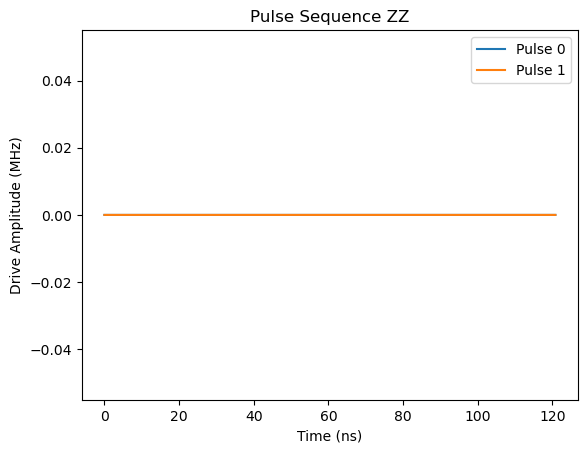

gg prob 1.0
ge prob 0.0
eg prob 0.0
ee prob 0.0
gg prob 0.0
ge prob 0.9999999999999998
eg prob 0.0
ee prob 0.0
gg prob 0.0
ge prob 0.0
eg prob 1.0
ee prob 0.0


 11%|█         | 1/9 [00:11<01:34, 11.82s/it]

gg prob 0.0
ge prob 0.0
eg prob 0.0
ee prob 1.0
ZX
ge
fd 4.426855887700232
pulse length 11.6
amp 0.00900774892748135
phase rad 1.5707963267948966
drive q 1
[-0.15915494309189535, 4.426855887700232] (GHz)
[0, 0.00900774892748135] (GHz)
[74.4, 46.4] (ns)
total pulse length 120.80000000000001 ns


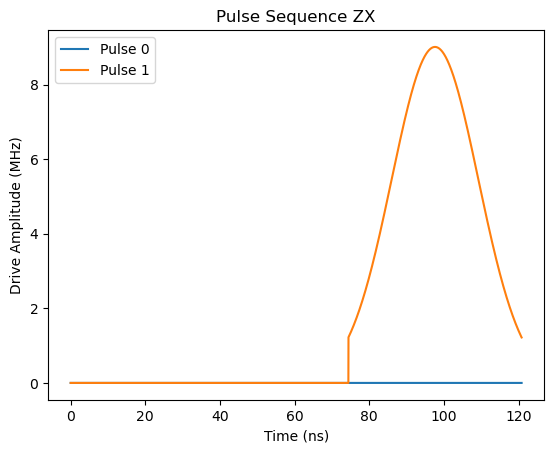

gg prob 0.5005431239900359
ge prob 0.4994568760099643
eg prob 0.0
ee prob 0.0
gg prob 0.5006540775893682
ge prob 0.49934592241063164
eg prob 0.0
ee prob 0.0
gg prob 0.0
ge prob 0.0
eg prob 0.5053936762791256
ee prob 0.49460632372087443


 22%|██▏       | 2/9 [00:24<01:26, 12.30s/it]

gg prob 0.0
ge prob 0.0
eg prob 0.494438513775039
ee prob 0.5055614862249609
ZY
ge
fd 4.426855887700232
pulse length 11.6
amp 0.00900774892748135
phase rad 0.0
drive q 1
[-0.15915494309189535, 4.426855887700232] (GHz)
[0, 0.00900774892748135] (GHz)
[74.4, 46.4] (ns)
total pulse length 120.80000000000001 ns


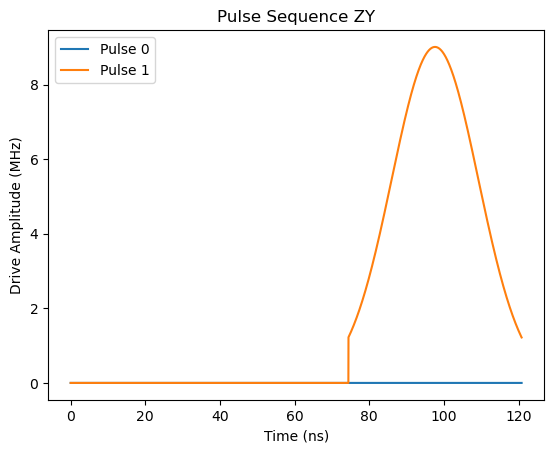

gg prob 0.5006422982688972
ge prob 0.49935770173110294
eg prob 0.0
ee prob 0.0
gg prob 0.5005545901120404
ge prob 0.4994454098879593
eg prob 0.0
ee prob 0.0
gg prob 0.0
ge prob 0.0
eg prob 0.5055454665721207
ee prob 0.4944545334278794


 33%|███▎      | 3/9 [00:37<01:15, 12.54s/it]

gg prob 0.0
ge prob 0.0
eg prob 0.49428679830778
ee prob 0.5057132016922204
XZ
eg
fd 4.806428472934725
pulse length 18.6
amp 0.005617735890257185
phase rad 1.5707963267948966
drive q 0
[4.806428472934725, -0.15915494309189535] (GHz)
[0.005617735890257185, 0] (GHz)
[74.4, 46.4] (ns)
total pulse length 120.80000000000001 ns


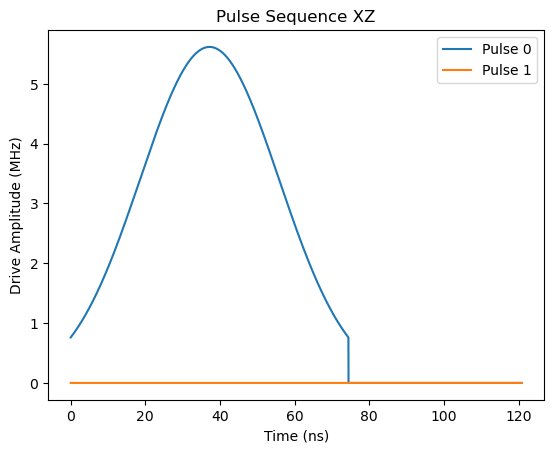

gg prob 0.5018678297889495
ge prob 0.0
eg prob 0.4981321702110506
ee prob 0.0
gg prob 0.0
ge prob 0.5140934800323173
eg prob 0.0
ee prob 0.4859065199676831
gg prob 0.5019341103791478
ge prob 0.0
eg prob 0.4980658896208526
ee prob 0.0


 44%|████▍     | 4/9 [00:52<01:07, 13.44s/it]

gg prob 0.0
ge prob 0.48566196582271576
eg prob 0.0
ee prob 0.5143380341772843
XX
eg
fd 4.806428472934725
pulse length 18.6
amp 0.005617735890257185
phase rad 1.5707963267948966
drive q 0
ge
fd 4.426855887700232
pulse length 11.6
amp 0.00900774892748135
phase rad 1.5707963267948966
drive q 1
[4.806428472934725, 4.426855887700232] (GHz)
[0.005617735890257185, 0.00900774892748135] (GHz)
[74.4, 46.4] (ns)
total pulse length 120.80000000000001 ns


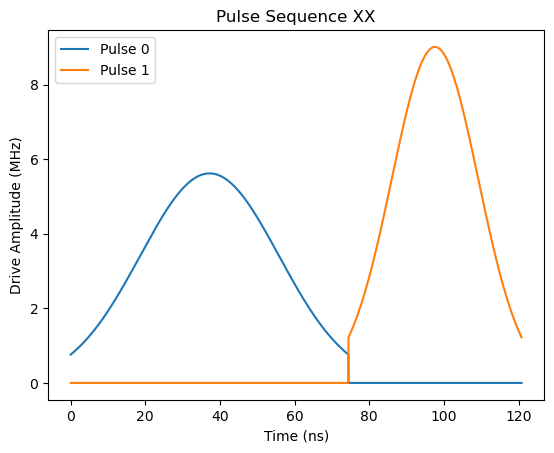

gg prob 0.25077851202204304
ge prob 0.25057246153181795
eg prob 0.2520019505200532
ee prob 0.2466470759260859
gg prob 0.25725136672325405
ge prob 0.2569181488050232
eg prob 0.24020248380560727
ee prob 0.2456280006661153
gg prob 0.2508116669424138
ge prob 0.2506055886846353
eg prob 0.2519684532278689
ee prob 0.2466142911450816


 56%|█████▌    | 5/9 [01:07<00:55, 13.97s/it]

gg prob 0.2430262571335191
ge prob 0.2427115821499735
eg prob 0.25425960931445174
ee prob 0.2600025514020559
XY
eg
fd 4.806428472934725
pulse length 18.6
amp 0.005617735890257185
phase rad 1.5707963267948966
drive q 0
ge
fd 4.426855887700232
pulse length 11.6
amp 0.00900774892748135
phase rad 0.0
drive q 1
[4.806428472934725, 4.426855887700232] (GHz)
[0.005617735890257185, 0.00900774892748135] (GHz)
[74.4, 46.4] (ns)
total pulse length 120.80000000000001 ns


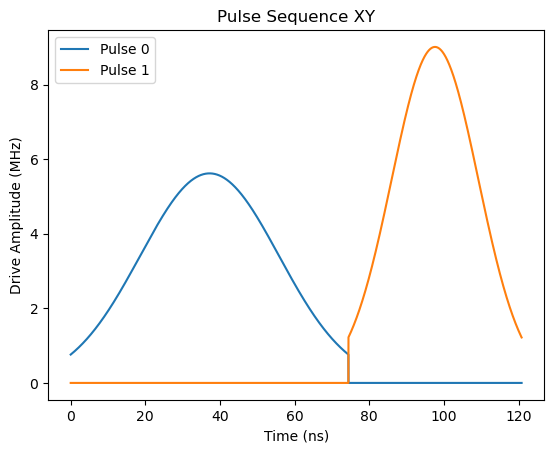

gg prob 0.250828426623186
ge prob 0.25052299297355174
eg prob 0.25207742026393376
ee prob 0.2465711601393288
gg prob 0.2572003435131811
ge prob 0.25696918840279465
eg prob 0.24012876800988028
ee prob 0.24570170007414377
gg prob 0.2508615893745413
ge prob 0.2505561148071202
eg prob 0.2520439116679948
ee prob 0.2465383841503437


 67%|██████▋   | 6/9 [01:21<00:42, 14.28s/it]

gg prob 0.2429780562148767
ge prob 0.24275980030394356
eg prob 0.25418157957545384
ee prob 0.26008056390572576
YZ
eg
fd 4.806428472934725
pulse length 18.6
amp 0.005617735890257185
phase rad 0.0
drive q 0
[4.806428472934725, -0.15915494309189535] (GHz)
[0.005617735890257185, 0] (GHz)
[74.4, 46.4] (ns)
total pulse length 120.80000000000001 ns


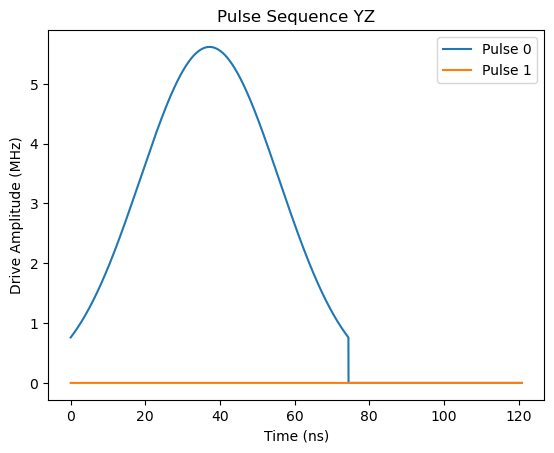

gg prob 0.5019476867678959
ge prob 0.0
eg prob 0.49805231323210447
ee prob 0.0
gg prob 0.0
ge prob 0.5141291456308485
eg prob 0.0
ee prob 0.48587085436915184
gg prob 0.5018542368848132
ge prob 0.0
eg prob 0.49814576311518693
ee prob 0.0


 78%|███████▊  | 7/9 [01:36<00:28, 14.31s/it]

gg prob 0.0
ge prob 0.48562625343498417
eg prob 0.0
ee prob 0.5143737465650159
YX
eg
fd 4.806428472934725
pulse length 18.6
amp 0.005617735890257185
phase rad 0.0
drive q 0
ge
fd 4.426855887700232
pulse length 11.6
amp 0.00900774892748135
phase rad 1.5707963267948966
drive q 1
[4.806428472934725, 4.426855887700232] (GHz)
[0.005617735890257185, 0.00900774892748135] (GHz)
[74.4, 46.4] (ns)
total pulse length 120.80000000000001 ns


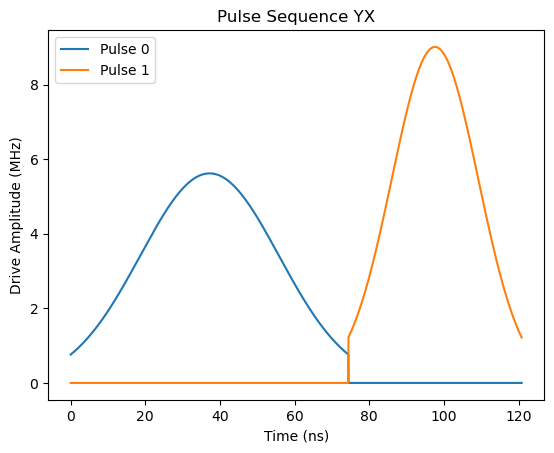

gg prob 0.2508184578909569
ge prob 0.2506123738941021
eg prob 0.25196159221471576
ee prob 0.24660757600022493
gg prob 0.2572692111029775
ge prob 0.2569359699053425
eg prob 0.24018485016341215
ee prob 0.2456099688282675
gg prob 0.25077171279837324
ge prob 0.25056566805387187
eg prob 0.25200881989409096
ee prob 0.24665379925366407


 89%|████████▉ | 8/9 [01:51<00:14, 14.54s/it]

gg prob 0.24300838905956193
ge prob 0.24269373735447158
eg prob 0.2542772663901213
ee prob 0.2600206071958454
YY
eg
fd 4.806428472934725
pulse length 18.6
amp 0.005617735890257185
phase rad 0.0
drive q 0
ge
fd 4.426855887700232
pulse length 11.6
amp 0.00900774892748135
phase rad 0.0
drive q 1
[4.806428472934725, 4.426855887700232] (GHz)
[0.005617735890257185, 0.00900774892748135] (GHz)
[74.4, 46.4] (ns)
total pulse length 120.80000000000001 ns


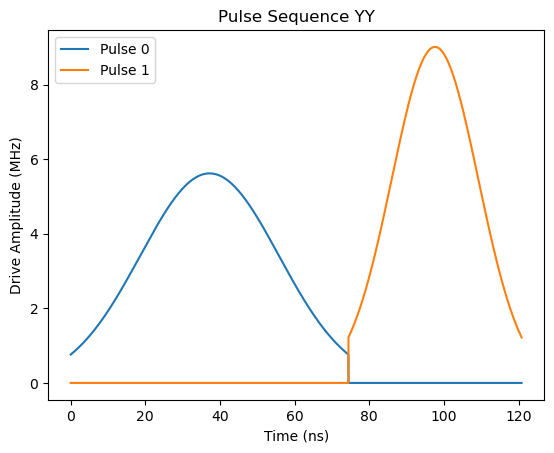

gg prob 0.25086838136617556
ge prob 0.2505628983835585
eg prob 0.2520370488603829
ee prob 0.24653167138988333
gg prob 0.2572181843313338
ge prob 0.25698701302259386
eg prob 0.24011113979860355
ee prob 0.2456836628474689
gg prob 0.2508216263800232
ge prob 0.2505162011553786
eg prob 0.2520842914109739
ee prob 0.24657788105362433


100%|██████████| 9/9 [02:06<00:00, 14.07s/it]

gg prob 0.2429601917083648
ge prob 0.24274195198546136
eg prob 0.2541992312133618
ee prob 0.26009862509281184
{'ZZ': array([[ 1.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ],
       [ 0.        +0.j        ,  0.08526613+0.99635821j,
         0.        +0.j        ,  0.        +0.j        ],
       [ 0.        +0.j        ,  0.        +0.j        ,
        -0.74595628+0.66599491j,  0.        +0.j        ],
       [ 0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.40225457-0.91552786j]]), 'ZX': array([[ 0.70749068+2.33866002e-04j, -0.00214561+7.07565880e-01j,
         0.        +0.00000000e+00j,  0.        +0.00000000e+00j],
       [-0.70396379+6.23847403e-02j,  0.06048949+7.04050384e-01j,
         0.        +0.00000000e+00j,  0.        +0.00000000e+00j],
       [ 0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
        -0.5065526 +4.98796693e-01j,  0.18476957-6.78453183e-01j],
       [

In [858]:
f_ge = np.array([f + (4000 if f < 1000 else 0) for f in yaml_cfg.device.qubit.f_ge]) # MHz
f_ef = np.array([f + (4000 if f < 1000 else 0) for f in yaml_cfg.device.qubit.f_ef]) # Mhz
# gs = np.array([51, 51, 36, 9, 8, 3.5]) # MHz

q0, q1 = qubits
ZZs_4q = np.reshape(np.array(yaml_cfg.device.qubit.ZZs), (4,4)) # MHz
f_ge = np.array([f_ge[q0], f_ge[q1]])
f_ef = np.array([f_ef[q0], f_ef[q1]])
alphas = f_ef - f_ge # MHz
ZZs = np.array([[0., 0.], [0., 0.]])
# ZZs = np.array([[100., 100.], [100., 100.]])
ZZs[0, 1] = ZZs_4q[q0, q1]
ZZs[1, 0] = ZZs_4q[q1, q0]

print('qubit freqs', f_ge)
# print('alphas', alphas)
print('ZZs', ZZs, '2pi*average', 2*pi*1e-3*np.average([ZZs[0,1], ZZs[1,0]]))
# print(pulse_dict)

evol_mats = get_evol_mats(qubits=qubits, qfreqs=f_ge*1e-3, ZZs=-ZZs*1e-3, pulse_dict=pulse_dict)
# evol_mats = get_evol_mats(qubits=qubits, qfreqs=f_ge*1e-3, alphas=alphas*1e-3, gs=gs*1e-3, pulse_dict=pulse_dict)

print(evol_mats)

In [926]:
# evol_mats_flat = []
# for basis in meas_order:
#     for i in range(4):
#         evol_mats_flat.append(qt.Qobj(evol_mats[basis][:,i], dims=psi_id.dims, shape=psi_id.shape))
# print(evol_mats_flat)

In [927]:
device = QSwitch(qubit_freqs=f_ge*1e-3, ZZs=-ZZs*1e-3, cutoffs=[2,2], useZZs=True, is2Q=True)
print(ZZs)
print(device.H.eigenenergies())
# print(device.H.eigenstates())


[[ 0.         -0.06125637]
 [ 3.31273346  0.        ]]
[ 0.         27.81475587 30.19968076 58.00422182]


Run MLE with ZZ correction

Convergence: True
Fidelity (with ZZ correction): 0.49791503835797435
Purity (with ZZ correction): 0.48016746026927715
Target purity: 0.6387201202762469
[[ 0.504+0.j     0.094-0.056j  0.12 -0.142j  0.02 -0.022j]
 [ 0.094+0.056j  0.296+0.j    -0.013-0.05j  -0.001+0.016j]
 [ 0.12 +0.142j -0.013+0.05j   0.194+0.j    -0.007+0.002j]
 [ 0.02 +0.022j -0.001-0.016j -0.007-0.002j  0.006+0.j   ]]


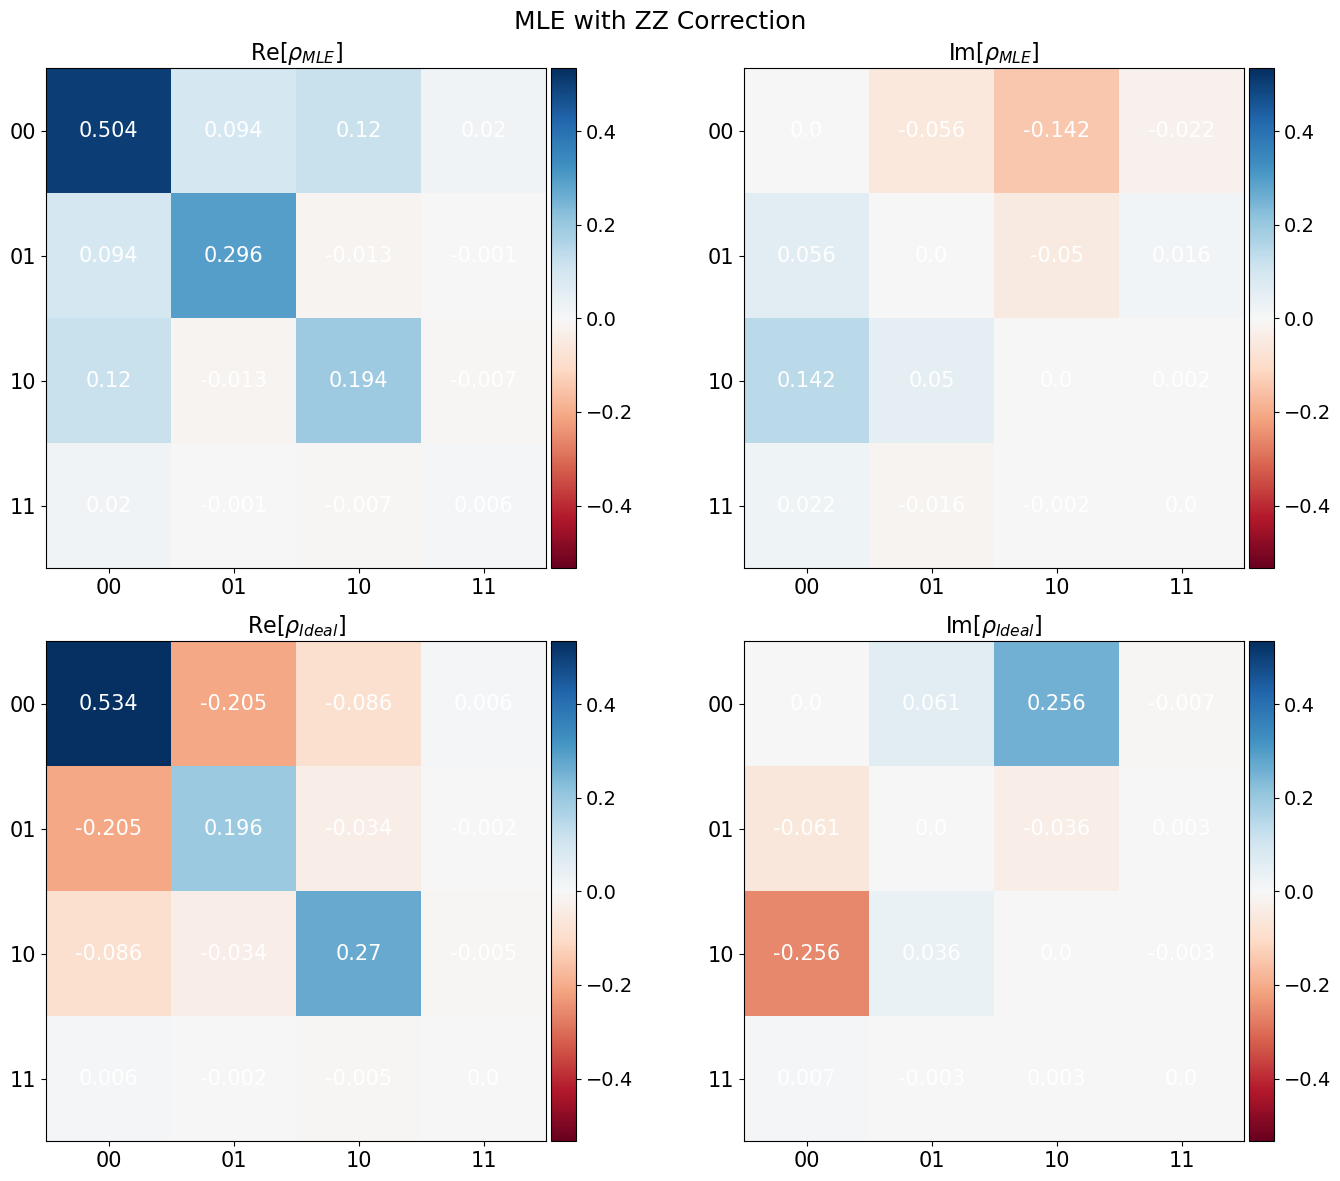

In [938]:
# rho_MLE_ZZ = run_MLE(n=n_tomo, rho_guess=rho_MLE_base, rho_id=rho_id, ZZ_correction=True, evol_mats=evol_mats)
rho_MLE_ZZ = run_MLE(n=n_tomo, rho_guess=rho_from_counts(n_tomo), rho_id=rho_id, ZZ_correction=True, evol_mats=evol_mats)
# rho_MLE_ZZ = run_MLE(n=fix_neg_counts(correct_readout_err(n_tomo, n_calib)), rho_guess=rho_MLE_base, rho_id=rho_id, ZZ_correction=True, evol_mats=evol_mats)
fid_ZZ = qt.fidelity(qt.Qobj(rho_MLE_ZZ, dims=rho_id.dims), rho_id)**2 # qutip uses N&C fidelity which is "sqrt fidelity"
purity_ZZ = np.real(np.trace(rho_MLE_ZZ @ rho_MLE_ZZ))
purity_id = np.real(np.trace(rho_id.full() @ rho_id.full()))
print(f'Fidelity (with ZZ correction): {fid_ZZ}')
print(f'Purity (with ZZ correction): {purity_ZZ}')
print(f'Target purity: {purity_id}')
print(np.around(rho_MLE_ZZ, decimals=3))
show_plot_rho_2d(rho_MLE_ZZ, rho_id, title='MLE with ZZ Correction') #, cmax=1.0)

Optimize over virtual Z gate on rho_id

100%|██████████| 75/75 [00:19<00:00,  3.86it/s]


Improved fidelity by (%) 41.30279917714284
Fidelity (after rotation): 0.9109430301294027
Purity (after rotation): 0.48016746026927715
Target purity: 0.6387201206200689
Best rotation: [155.67567567567568, 199.45945945945945]
[[ 0.504+0.j     0.094-0.056j  0.12 -0.142j  0.02 -0.022j]
 [ 0.094+0.056j  0.296+0.j    -0.013-0.05j  -0.001+0.016j]
 [ 0.12 +0.142j -0.013+0.05j   0.194+0.j    -0.007+0.002j]
 [ 0.02 +0.022j -0.001-0.016j -0.007-0.002j  0.006+0.j   ]]


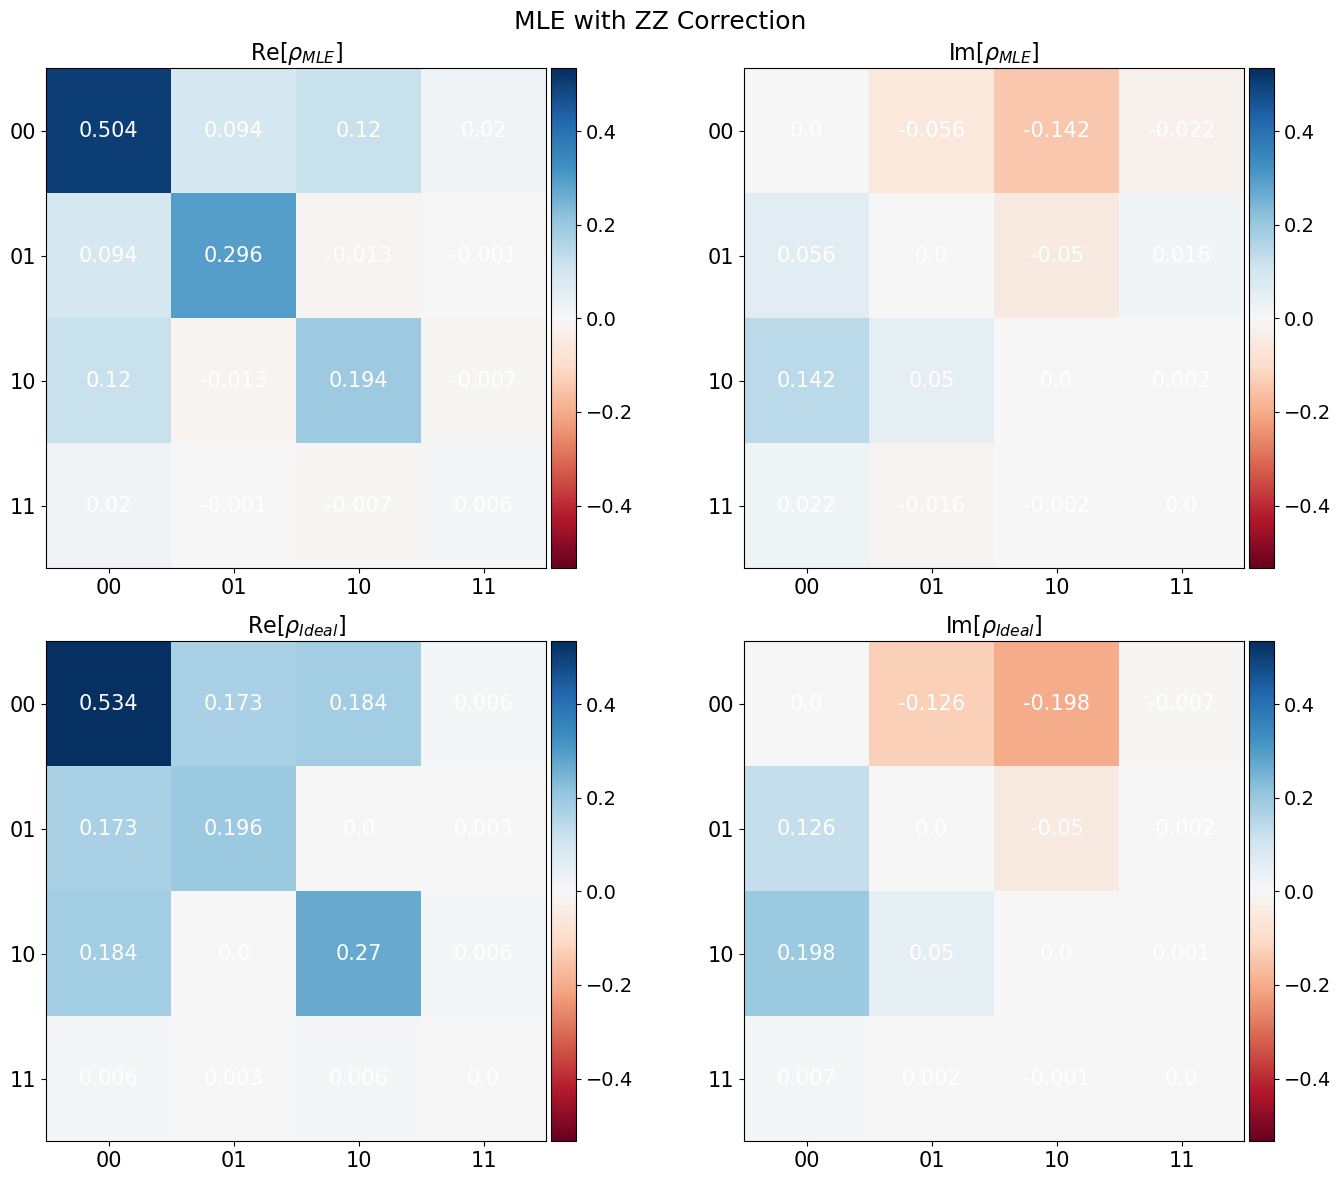

In [939]:
rho_id_rot, best_phis, best_fid = opt_virtualZ_MLE(qt.Qobj(rho_MLE_ZZ, dims=rho_id.dims), rho_id, nphi=75)

fid_ZZ_rot = best_fid
purity_ZZ_rot = np.real(np.trace(rho_MLE_ZZ @ rho_MLE_ZZ))
purity_id_rot = np.real(np.trace(rho_id_rot.full() @ rho_id_rot.full()))
print(f'Fidelity (after rotation): {fid_ZZ_rot}')
print(f'Purity (after rotation): {purity_ZZ_rot}')
print(f'Target purity: {purity_id_rot}')
print(f'Best rotation: {best_phis}')

print(np.around(rho_MLE_ZZ, decimals=3))
show_plot_rho_2d(rho_MLE_ZZ, rho_id_rot, title='MLE with ZZ Correction') #, cmax=1.0)

In [337]:
# tomo.save_data()